In [1]:
import nn_module as nnm
import torch
import numpy as np
import numpy.ma as ma
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math
import time
import copy
import pandas as pd
from pandas import read_csv
import argparse
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
out_file = '15708_2'
data_dict = {}
pp = PdfPages(f'./graphs/{out_file}_validation.pdf')

In [3]:
# The mapping between the WC names and their positions in the data
# There are Combine 1D scans over all 16 WCs
names = {}
names['cQei'] = 0
names['cQl3i'] = 1
names['cQlMi'] = 2
names['cbW'] = 3
names['cpQ3'] = 4
names['cpQM'] = 5
names['cpt'] = 6
names['cptb'] = 7
names['ctG'] = 8
names['ctW'] = 9
names['ctZ'] = 10
names['ctei'] = 11
names['ctlSi'] = 12
names['ctlTi'] = 13
names['ctli'] = 14
names['ctp'] = 15

# Pairs of WCs in existing Combine 2D scans
WC2d_1 = ['cpQ3', 'cpQM', 'cpt', 'cptb', 'cQei', 'ctei', 'ctli', 'ctW'] # The first of the two WCs to graph
WC2d_2 = ['cbW', 'ctG', 'ctp', 'cQl3i', 'cQlMi', 'ctlTi', 'ctlSi', 'ctZ'] # The second of the two WCs to graph

# Hyperparameters for profiling
profile_parameters = {}
profile_parameters['batch_size'] = 4096
profile_parameters['epochs'] = 200
profile_parameters['learning_rate'] = 4e-0
profile_parameters['lr_red_factor'] = 0.2
profile_parameters['lr_red_patience'] = 1
profile_parameters['lr_red_threshold'] = 1e-6
profile_parameters['rand_pts'] = 50 # The number of random starting points to do gradient descent on for each scanned value
profile_parameters['rand_stdev'] = 40

# general paremeters
batch_size = 4096 # for frozen graphs

In [4]:
save_dict = torch.load(f'../models/{out_file}_model+.pt')
best_model_state = save_dict['model']
parameters_save = save_dict['parameters']
input_stats = save_dict['input_stats']
output_stats = save_dict['output_stats']

In [5]:
# Check to make sure we're on cuda
input_stats[0].device

device(type='cuda', index=0)

In [6]:
# Check memory usage
torch.cuda.memory_allocated() / 1e9

0.004361728

In [7]:
parameters_save

{'N': 16,
 'train_size': 49378587,
 'test_size': 498773,
 'hidden_nodes': 700,
 'hidden_layers': 2,
 'batch_size': 512,
 'n_epochs': 271,
 'learning_rate': 0.0001,
 'lr_red_factor': 0.2,
 'lr_red_patience': 20.0,
 'lr_red_threshold': 1e-06,
 'weight_decay': 0.0,
 'polynomial': True,
 'polynomial_degree': 2,
 'accu_out_resolution': 100,
 'out_residual_resolution': 100}

In [8]:
# TODO: Cheat a little. Fix later by training with the additional layers.
'''
parameters_save['polynomial'] = True
parameters_save['polynomial_degree'] = 2
best_model_state['1.linear.weight'] = best_model_state.pop('0.linear.weight')
best_model_state['1.linear.bias'] = best_model_state.pop('0.linear.bias')
best_model_state['3.weight'] = best_model_state.pop('2.weight')
best_model_state['3.bias'] = best_model_state.pop('2.bias')
best_model_state['5.weight'] = best_model_state.pop('4.weight')
best_model_state['5.bias'] = best_model_state.pop('4.bias')
best_model_state['7.weight'] = best_model_state.pop('6.weight')
best_model_state['7.bias'] = best_model_state.pop('6.bias')
'''

"\nparameters_save['polynomial'] = True\nparameters_save['polynomial_degree'] = 2\nbest_model_state['1.linear.weight'] = best_model_state.pop('0.linear.weight')\nbest_model_state['1.linear.bias'] = best_model_state.pop('0.linear.bias')\nbest_model_state['3.weight'] = best_model_state.pop('2.weight')\nbest_model_state['3.bias'] = best_model_state.pop('2.bias')\nbest_model_state['5.weight'] = best_model_state.pop('4.weight')\nbest_model_state['5.bias'] = best_model_state.pop('4.bias')\nbest_model_state['7.weight'] = best_model_state.pop('6.weight')\nbest_model_state['7.bias'] = best_model_state.pop('6.bias')\n"

In [9]:
best_model_state.keys()

odict_keys(['2.linear.weight', '2.linear.bias', '4.weight', '4.bias', '6.weight', '6.bias', '8.weight', '8.bias'])

In [10]:
model = nnm.create_model(16, 1, parameters_save, input_stats, output_stats)
model.load_state_dict(best_model_state)
model.eval()

Sequential(
  (0): LinearLayer()
  (1): LinearLayer()
  (2): PolynomialLayer(
    (monomial_layer): MonomialLayer()
    (linear): Linear(in_features=152, out_features=700, bias=True)
  )
  (3): ReLU()
  (4): Linear(in_features=700, out_features=700, bias=True)
  (5): ReLU()
  (6): Linear(in_features=700, out_features=700, bias=True)
  (7): ReLU()
  (8): Linear(in_features=700, out_features=1, bias=True)
  (9): LinearLayer()
)

In [11]:
# Data for 1D frozen graphs compared to Combine scans
target_1d_frozen_data = {}
for key in names.keys():
    loaded = np.load(f'likelihood_{key}.npz')
    target_1d_frozen_data[key] = {key: loaded[key], '2dNLL': loaded['deltaNLL']}
    target_1d_frozen_data[key]['2dNLL'] *= 2

target_1d_zoomed_frozen_data = {}
for key in names.keys():
    less_than_10 = (target_1d_frozen_data[key]['2dNLL'] < 10)
    target_1d_zoomed_frozen_data[key] = {key: target_1d_frozen_data[key][key][less_than_10], '2dNLL': target_1d_frozen_data[key]['2dNLL'][less_than_10]}

model_1d_frozen_data = {}
diff_1d_frozen_data = {}
for key in names.keys():
    inputs = target_1d_frozen_data[key][key]
    num_inputs = inputs.shape[0]
    # Now requires model to have been trained with the polynomial layer
    if (parameters_save['polynomial']):
        inputs_all = np.zeros((num_inputs, 16))
        inputs_all[:,names[key]] = inputs
    else:
        raise RuntimeError(f'Models without the polynomial layer are no longer supported! The number of inputs must match the number of WCs.')
    outputs = model(torch.from_numpy(inputs_all).float().cuda()).cpu().detach().numpy().flatten()
    outputs *= 2
    model_1d_frozen_data[key] = {key: inputs, '2dNLL': outputs}
    diff_1d_frozen_data[key] = {key: inputs, '2dNLL': target_1d_frozen_data[key]['2dNLL'] - model_1d_frozen_data[key]['2dNLL']}
    
model_1d_zoomed_frozen_data = {}
diff_1d_zoomed_frozen_data = {}
for key in names.keys():
    less_than_10 = (target_1d_frozen_data[key]['2dNLL'] < 10)
    model_1d_zoomed_frozen_data[key] = {key: model_1d_frozen_data[key][key][less_than_10], '2dNLL': model_1d_frozen_data[key]['2dNLL'][less_than_10]}
    diff_1d_zoomed_frozen_data[key] = {key: diff_1d_frozen_data[key][key][less_than_10], '2dNLL': diff_1d_frozen_data[key]['2dNLL'][less_than_10]}

In [12]:
# Save the data
data_dict['target_1d_frozen_data'] = copy.deepcopy(target_1d_frozen_data)
data_dict['model_1d_frozen_data'] = copy.deepcopy(model_1d_frozen_data)
data_dict['diff_1d_frozen_data'] = copy.deepcopy(diff_1d_frozen_data)

In [13]:
# TODO (WARNING): cpQ3, cpQM, ctG, cpt, ctW, ctZ have new data and it doesn't have the other WCs saved.
# So the fake profiled graphs don't work now.
# Data for 1D fake profiled graphs compared to Combine scans
# Target data
target_1d_fake_profiled_data = {}
for key in names.keys():
    loaded = np.load(f'likelihood_profiled_{key}.npz')
    inputs = np.zeros((loaded['deltaNLL'].shape[0], 16))
    for key2 in names.keys():
        inputs[:,names[key2]] = loaded[key2]
    target_1d_fake_profiled_data[key] = {'all_WCs': inputs, '2dNLL': loaded['deltaNLL']} # Inputs here contain all the WCs
    target_1d_fake_profiled_data[key]['2dNLL'] *= 2
    
target_1d_zoomed_fake_profiled_data = {}
for key in names.keys():
    less_than_10 = (target_1d_fake_profiled_data[key]['2dNLL'] < 10)
    target_1d_zoomed_fake_profiled_data[key] = {'all_WCs': target_1d_fake_profiled_data[key]['all_WCs'][less_than_10], '2dNLL': target_1d_fake_profiled_data[key]['2dNLL'][less_than_10]}

In [14]:
# Save the data
data_dict['target_1d_fake_profiled_data'] = copy.deepcopy(target_1d_fake_profiled_data)

In [15]:
# Model and diff data
model_1d_fake_profiled_data = {}
diff_1d_fake_profiled_data = {}
for key in names.keys():
    inputs = target_1d_fake_profiled_data[key]['all_WCs']
    # Now requires model to have been trained with the polynomial layer
    if not (parameters_save['polynomial']):
        raise RuntimeError(f'Models without the polynomial layer are no longer supported! The number of inputs must match the number of WCs.')
    outputs = model(torch.from_numpy(inputs).float().cuda()).cpu().detach().numpy().flatten()
    outputs *= 2
    model_1d_fake_profiled_data[key] = {'all_WCs': inputs, '2dNLL': outputs}
    diff_1d_fake_profiled_data[key] = {'all_WCs': inputs, '2dNLL': target_1d_fake_profiled_data[key]['2dNLL'] - outputs}
    
model_1d_zoomed_fake_profiled_data = {}
diff_1d_zoomed_fake_profiled_data = {}
for key in names.keys():
    less_than_10 = (target_1d_fake_profiled_data[key]['2dNLL'] < 10)
    model_1d_zoomed_fake_profiled_data[key] = {'all_WCs': model_1d_fake_profiled_data[key]['all_WCs'][less_than_10], '2dNLL': model_1d_fake_profiled_data[key]['2dNLL'][less_than_10]}
    diff_1d_zoomed_fake_profiled_data[key] = {'all_WCs': diff_1d_fake_profiled_data[key]['all_WCs'][less_than_10], '2dNLL': diff_1d_fake_profiled_data[key]['2dNLL'][less_than_10]}

In [16]:
# Save the data
data_dict['model_1d_fake_profiled_data'] = copy.deepcopy(model_1d_fake_profiled_data)
data_dict['diff_1d_fake_profiled_data'] = copy.deepcopy(diff_1d_fake_profiled_data)

In [17]:
# Data for 2D frozen graphs compared to Combine scans
target_2d_frozen_data = {}
for num in np.arange(8):
    WC1 = WC2d_1[num]
    WC2 = WC2d_2[num]
    loaded = np.load(f'likelihood_{WC1}_{WC2}.npz')
    target_2d_frozen_data[str(num)] = {WC1: loaded[WC1], WC2: loaded[WC2], '2dNLL': loaded['deltaNLL']}
    target_2d_frozen_data[str(num)]['2dNLL'] *= 2

model_2d_frozen_data = {}
diff_2d_frozen_data = {}
for num in np.arange(8):
    inputs_y = target_2d_frozen_data[str(num)][WC2d_1[num]]
    inputs_x = target_2d_frozen_data[str(num)][WC2d_2[num]]
    num_inputs = inputs_y.shape[0]
    inputs = np.zeros((num_inputs, 16))
    inputs[:,names[WC2d_1[num]]] = inputs_y
    inputs[:,names[WC2d_2[num]]] = inputs_x
    inputs = torch.from_numpy(inputs).float().cuda()
    
    inputMiniBatches = torch.split(inputs, batch_size)
    outputs = torch.zeros((num_inputs, 1)).cuda()
    batch_idx = 0
    for minibatch in range(len(inputMiniBatches)):
        batch_inputs = inputMiniBatches[minibatch]
        this_batch_size = batch_inputs.shape[0]
        outputs[batch_idx: batch_idx + this_batch_size] = model(batch_inputs)
        batch_idx += this_batch_size
    
    outputs = outputs.cpu().detach().numpy().flatten()
    outputs *= 2
    model_2d_frozen_data[str(num)] = {WC2d_1[num]: target_2d_frozen_data[str(num)][WC2d_1[num]], WC2d_2[num]: target_2d_frozen_data[str(num)][WC2d_2[num]], '2dNLL': outputs}
    diff_2d_frozen_data[str(num)] = {WC2d_1[num]: target_2d_frozen_data[str(num)][WC2d_1[num]], WC2d_2[num]: target_2d_frozen_data[str(num)][WC2d_2[num]], '2dNLL': target_2d_frozen_data[str(num)]['2dNLL'] - outputs}

In [18]:
inputs = torch.randn((200000,16)).cuda()
start_time = time.perf_counter()
model(inputs)
print ((time.perf_counter() - start_time)/inputs.shape[0])

2.400715951807797e-08


In [19]:
# Save the data
data_dict['target_2d_frozen_data'] = copy.deepcopy(target_2d_frozen_data)
data_dict['model_2d_frozen_data'] = copy.deepcopy(model_2d_frozen_data)
data_dict['diff_2d_frozen_data'] = copy.deepcopy(diff_2d_frozen_data)

In [20]:
# Data for 2D fake profiled graphs compared to Combine scans
# Target data
target_2d_profiled_data = {}
for num in np.arange(8):
    WC1 = WC2d_1[num]
    WC2 = WC2d_2[num]
    loaded = np.load(f'likelihood_profiled_{WC1}_{WC2}.npz')
    inputs = np.zeros((loaded['deltaNLL'].shape[0], 16))
    for key2 in names.keys():
        inputs[:,names[key2]] = loaded[key2]
    target_2d_profiled_data[str(num)] = {'all_WCs': inputs, '2dNLL': loaded['deltaNLL']} # Inputs here contain all the WCs
    target_2d_profiled_data[str(num)]['2dNLL'] *= 2

In [21]:
# Save the data
data_dict['target_2d_profiled_data'] = copy.deepcopy(target_2d_profiled_data)

In [22]:
# Model data
model_2d_fake_profiled_data = {}
for num in np.arange(8):
    inputs = target_2d_profiled_data[str(num)]['all_WCs']
    num_inputs = inputs.shape[0]
    inputs = torch.from_numpy(inputs).float().cuda()
    
    inputMiniBatches = torch.split(inputs, batch_size)
    outputs = torch.zeros((num_inputs, 1)).cuda()
    batch_idx = 0
    for minibatch in range(len(inputMiniBatches)):
        batch_inputs = inputMiniBatches[minibatch]
        this_batch_size = batch_inputs.shape[0]
        outputs[batch_idx: batch_idx + this_batch_size] = model(batch_inputs)
        batch_idx += this_batch_size
    
    outputs = outputs.cpu().detach().numpy().flatten()
    outputs *= 2
    model_2d_fake_profiled_data[str(num)] = {'all_WCs': target_2d_profiled_data[str(num)]['all_WCs'], '2dNLL': outputs}

In [23]:
# Save the data
data_dict['model_2d_fake_profiled_data'] = copy.deepcopy(model_2d_fake_profiled_data)

In [24]:
# Data for 1D real profiled graphs compared to Combine scans
# Target data
target_1d_profiled_data = {}
for key in names.keys():
    loaded = np.load(f'likelihood_profiled_{key}.npz')
    target_1d_profiled_data[key] = {key: loaded[key], '2dNLL': loaded['deltaNLL']}
    target_1d_profiled_data[key]['2dNLL'] *= 2

target_1d_zoomed_profiled_data = {}
for key in names.keys():
    less_than_10 = (target_1d_profiled_data[key]['2dNLL'] < 10)
    target_1d_zoomed_profiled_data[key] = {key: target_1d_profiled_data[key][key][less_than_10], '2dNLL': target_1d_profiled_data[key]['2dNLL'][less_than_10]}

In [25]:
# Model and diff data
model_1d_profiled_data = {}
diff_1d_profiled_data = {}
for key in names.keys():
    inputs = target_1d_profiled_data[key][key]
    num_inputs = inputs.shape[0]
    # Now requires model to have been trained with the polynomial layer
    if not (parameters_save['polynomial']):
        raise RuntimeError(f'Models without the polynomial layer are no longer supported! The number of inputs must match the number of WCs.')
    inputs_all = np.zeros((num_inputs, 16))
    inputs_all[:,names[key]] = inputs
    # profile() currently takes inputs as an np array not tensor. I know, confusing, so to be fixed in the future.
    (min_WCs_scanned, outputs) = nnm.profile(model, inputs_all, [names[key]], profile_parameters)
    min_WCs_scanned = min_WCs_scanned.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy().flatten()
    outputs *= 2
    model_1d_profiled_data[key] = {'all_WCs': min_WCs_scanned, '2dNLL': outputs}
    diff_1d_profiled_data[key] = {'all_WCs': model_1d_profiled_data[key]['all_WCs'], '2dNLL': target_1d_profiled_data[key]['2dNLL'] - outputs}
    
model_1d_zoomed_profiled_data = {}
diff_1d_zoomed_profiled_data = {}
for key in names.keys():
    less_than_10 = (target_1d_profiled_data[key]['2dNLL'] < 10)
    model_1d_zoomed_profiled_data[key] = {'all_WCs': model_1d_profiled_data[key]['all_WCs'][less_than_10], '2dNLL': model_1d_profiled_data[key]['2dNLL'][less_than_10]}
    diff_1d_zoomed_profiled_data[key] = {'all_WCs': diff_1d_profiled_data[key]['all_WCs'][less_than_10], '2dNLL': diff_1d_profiled_data[key]['2dNLL'][less_than_10]}

WC indices: 0 Starting 0/1 minibatches.
Starting 0/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 101162.9296875
Starting 1/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 92593.6875
Starting 2/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 83385.921875
Starting 3/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 75301.296875
Starting 4/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 68810.53125
Starting 5/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 66818.375
Starting 6/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 65868.890625
Starting 7/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 63437.31640625
Starting 8/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 60772.66015625
Starting 9/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 58953.1875
Starting 10/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 58149.55859375
St

Sum(log(minibatch outputs+10)): 45760.65234375
Starting 96/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45758.9921875
Starting 97/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45756.38671875
Starting 98/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45753.05078125
Starting 99/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45749.72265625
Starting 100/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45746.95703125
Starting 101/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45745.0
Starting 102/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45743.60546875
Starting 103/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45742.37890625
Starting 104/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45740.9765625
Starting 105/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45739.3828125
Starting 106/200 epochs of 0/1 minibatches.
Sum(log(minib

Sum(log(minibatch outputs+10)): 45710.12890625
Starting 192/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45710.0390625
Starting 193/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45709.9609375
Starting 194/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45709.87890625
Starting 195/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45709.80859375
Starting 196/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45709.7421875
Starting 197/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45709.67578125
Starting 198/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45709.6171875
Starting 199/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45709.53125
Profiling done!
Time used: 2.6012893659062684 seconds.
WC indices: 1 Starting 0/1 minibatches.
Starting 0/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 101135.40625
Starting 1/200 epochs of 0/1 minibatches.
Sum(log(

Sum(log(minibatch outputs+10)): 40839.4921875
Starting 86/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40849.84375
Starting 87/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40850.94140625
Starting 88/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40843.7890625
Starting 89/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40680.2109375
Starting 90/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40482.53125
Starting 91/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40468.0234375
Starting 92/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40487.3359375
Starting 93/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40449.25
Starting 94/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40424.8828125
Starting 95/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40423.31640625
Starting 96/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10

Sum(log(minibatch outputs+10)): 40163.7109375
Starting 182/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40163.2734375
Starting 183/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40162.9453125
Starting 184/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40162.703125
Starting 185/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40162.49609375
Starting 186/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40162.296875
Starting 187/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40162.1015625
Starting 188/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40161.8984375
Starting 189/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40161.6875
Starting 190/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40161.4765625
Starting 191/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40161.28125
Starting 192/200 epochs of 0/1 minibatches.
Sum(log(minibatc

Sum(log(minibatch outputs+10)): 46237.1328125
Starting 89/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46223.265625
Starting 90/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46209.40625
Starting 91/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46198.7109375
Starting 92/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46192.25
Starting 93/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46189.0
Starting 94/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46187.0390625
Starting 95/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46184.8515625
Starting 96/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46181.859375
Starting 97/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46178.4296875
Starting 98/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46175.140625
Starting 99/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46172

Sum(log(minibatch outputs+10)): 46131.9765625
Starting 185/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46131.87890625
Starting 186/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46131.7734375
Starting 187/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46131.6640625
Starting 188/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46131.56640625
Starting 189/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46131.4609375
Starting 190/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46131.3515625
Starting 191/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46131.2578125
Starting 192/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46131.15625
Starting 193/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46131.0546875
Starting 194/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46130.953125
Starting 195/200 epochs of 0/1 minibatches.
Sum(log(min

Sum(log(minibatch outputs+10)): 42748.7265625
Starting 81/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42692.6015625
Starting 82/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42674.828125
Starting 83/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42648.609375
Starting 84/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42622.859375
Starting 85/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42603.48046875
Starting 86/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42592.0859375
Starting 87/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42586.6328125
Starting 88/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42583.70703125
Starting 89/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42580.3203125
Starting 90/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42574.9765625
Starting 91/200 epochs of 0/1 minibatches.
Sum(log(minibatch outp

Sum(log(minibatch outputs+10)): 42489.1015625
Starting 177/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42488.9609375
Starting 178/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42488.8046875
Starting 179/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42488.6328125
Starting 180/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42488.4921875
Starting 181/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42488.3359375
Starting 182/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42488.17578125
Starting 183/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42488.0390625
Starting 184/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42487.90625
Starting 185/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42487.7734375
Starting 186/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42487.62890625
Starting 187/200 epochs of 0/1 minibatches.
Sum(log(mi

Sum(log(minibatch outputs+10)): 45273.1484375
Starting 72/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45263.6640625
Starting 73/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45273.9765625
Starting 74/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45266.14453125
Starting 75/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45245.43359375
Starting 76/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45089.4296875
Starting 77/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44924.8828125
Starting 78/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44963.015625
Starting 79/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44985.25390625
Starting 80/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44908.82421875
Starting 81/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44888.984375
Starting 82/200 epochs of 0/1 minibatches.
Sum(log(minibatch o

Sum(log(minibatch outputs+10)): 44721.28515625
Starting 168/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44721.12109375
Starting 169/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44720.9609375
Starting 170/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44720.8046875
Starting 171/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44720.6640625
Starting 172/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44720.4921875
Starting 173/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44720.328125
Starting 174/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44720.1640625
Starting 175/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44720.00390625
Starting 176/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44719.8359375
Starting 177/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44719.6953125
Starting 178/200 epochs of 0/1 minibatches.
Sum(log(

Sum(log(minibatch outputs+10)): 44819.1171875
Starting 63/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44808.25
Starting 64/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44790.3671875
Starting 65/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44798.00390625
Starting 66/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44790.5078125
Starting 67/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44772.7265625
Starting 68/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44646.796875
Starting 69/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44504.7265625
Starting 70/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44518.66796875
Starting 71/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44521.69140625
Starting 72/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44459.28125
Starting 73/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+

Sum(log(minibatch outputs+10)): 44286.59375
Starting 159/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44286.46484375
Starting 160/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44286.3671875
Starting 161/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44286.234375
Starting 162/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44286.1328125
Starting 163/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44286.0234375
Starting 164/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44285.88671875
Starting 165/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44285.7734375
Starting 166/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44285.640625
Starting 167/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44285.484375
Starting 168/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44285.3671875
Starting 169/200 epochs of 0/1 minibatches.
Sum(log(minib

Sum(log(minibatch outputs+10)): 42860.7109375
Starting 54/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42836.84375
Starting 55/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42811.74609375
Starting 56/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42785.2890625
Starting 57/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42762.3515625
Starting 58/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42744.7265625
Starting 59/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42718.69140625
Starting 60/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42705.2890625
Starting 61/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42688.59375
Starting 62/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42678.0078125
Starting 63/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42667.4296875
Starting 64/200 epochs of 0/1 minibatches.
Sum(log(minibatch outpu

Sum(log(minibatch outputs+10)): 42064.03125
Starting 149/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42063.8046875
Starting 150/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42063.55078125
Starting 151/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42063.265625
Starting 152/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42062.953125
Starting 153/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42062.65625
Starting 154/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42062.38671875
Starting 155/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42062.15625
Starting 156/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42061.921875
Starting 157/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42061.671875
Starting 158/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42061.453125
Starting 159/200 epochs of 0/1 minibatches.
Sum(log(minibatch o

Sum(log(minibatch outputs+10)): 46604.59765625
Starting 44/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46541.0234375
Starting 45/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46483.50390625
Starting 46/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46431.0859375
Starting 47/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46385.578125
Starting 48/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46340.2890625
Starting 49/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46295.75
Starting 50/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46254.68359375
Starting 51/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46239.54296875
Starting 52/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46209.671875
Starting 53/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46183.453125
Starting 54/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs

Sum(log(minibatch outputs+10)): 45388.46875
Starting 140/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45388.0390625
Starting 141/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45387.65234375
Starting 142/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45387.2734375
Starting 143/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45386.9140625
Starting 144/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45386.5546875
Starting 145/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45386.23046875
Starting 146/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45385.93359375
Starting 147/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45385.640625
Starting 148/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45385.33203125
Starting 149/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45385.046875
Starting 150/200 epochs of 0/1 minibatches.
Sum(log(mi

Sum(log(minibatch outputs+10)): 45528.296875
Starting 35/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45464.4140625
Starting 36/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45406.98046875
Starting 37/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45352.109375
Starting 38/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45304.390625
Starting 39/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45263.1171875
Starting 40/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45224.21484375
Starting 41/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45189.65625
Starting 42/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45157.17578125
Starting 43/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45128.7265625
Starting 44/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45103.76171875
Starting 45/200 epochs of 0/1 minibatches.
Sum(log(minibatch outp

Sum(log(minibatch outputs+10)): 44804.3515625
Starting 131/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44803.8359375
Starting 132/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44803.4765625
Starting 133/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44803.22265625
Starting 134/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44803.03515625
Starting 135/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44802.875
Starting 136/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44802.76171875
Starting 137/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44802.67578125
Starting 138/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44802.59765625
Starting 139/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44802.5078125
Starting 140/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44802.4296875
Starting 141/200 epochs of 0/1 minibatches.
Sum(log(m

Sum(log(minibatch outputs+10)): 44734.4140625
Starting 26/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44408.9921875
Starting 27/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 44124.8046875
Starting 28/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 43888.98828125
Starting 29/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 43662.3046875
Starting 30/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 43413.3359375
Starting 31/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 43239.30078125
Starting 32/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 43061.25390625
Starting 33/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42893.15625
Starting 34/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42738.46875
Starting 35/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42606.83984375
Starting 36/200 epochs of 0/1 minibatches.
Sum(log(minibatch out

Sum(log(minibatch outputs+10)): 40801.6328125
Starting 122/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40801.0078125
Starting 123/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40800.63671875
Starting 124/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40800.2734375
Starting 125/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40799.83984375
Starting 126/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40799.3515625
Starting 127/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40798.8359375
Starting 128/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40798.3203125
Starting 129/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40797.8046875
Starting 130/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40797.32421875
Starting 131/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 40796.921875
Starting 132/200 epochs of 0/1 minibatches.
Sum(log(

Sum(log(minibatch outputs+10)): 49817.40625
Starting 17/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 49169.5546875
Starting 18/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48650.41796875
Starting 19/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48249.52734375
Starting 20/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 47833.375
Starting 21/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 47422.47265625
Starting 22/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 47019.25390625
Starting 23/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46678.328125
Starting 24/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46369.48046875
Starting 25/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 46067.90625
Starting 26/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45782.13671875
Starting 27/200 epochs of 0/1 minibatches.
Sum(log(minibatch output

Sum(log(minibatch outputs+10)): 42448.4296875
Starting 113/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42447.53125
Starting 114/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42446.71875
Starting 115/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42445.8515625
Starting 116/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42444.8515625
Starting 117/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42443.7890625
Starting 118/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42442.765625
Starting 119/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42441.8515625
Starting 120/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42441.046875
Starting 121/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42440.34375
Starting 122/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 42439.7109375
Starting 123/200 epochs of 0/1 minibatches.
Sum(log(minibatch 

Sum(log(minibatch outputs+10)): 64386.55078125
Starting 8/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 61828.94140625
Starting 9/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 60215.90625
Starting 10/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 59342.453125
Starting 11/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 58537.640625
Starting 12/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 57526.96875
Starting 13/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 56553.90625
Starting 14/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 55817.796875
Starting 15/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 55258.984375
Starting 16/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 54697.3984375
Starting 17/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 54149.20703125
Starting 18/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10))

Sum(log(minibatch outputs+10)): 48318.3125
Starting 104/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48316.54296875
Starting 105/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48314.8125
Starting 106/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48313.5625
Starting 107/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48312.21875
Starting 108/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48310.5859375
Starting 109/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48309.33203125
Starting 110/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48308.453125
Starting 111/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48307.34375
Starting 112/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48306.3671875
Starting 113/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48305.5859375
Starting 114/200 epochs of 0/1 minibatches.
Sum(log(minibatch outp

Sum(log(minibatch outputs+10)): 48285.5
Profiling done!
Time used: 2.584014827036299 seconds.
WC indices: 12 Starting 0/1 minibatches.
Starting 0/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 101243.6953125
Starting 1/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 92665.1953125
Starting 2/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 83443.609375
Starting 3/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 75305.15625
Starting 4/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 68659.0
Starting 5/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 66683.5625
Starting 6/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 65704.3125
Starting 7/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 63251.453125
Starting 8/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 60444.67578125
Starting 9/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 58702.421875


Sum(log(minibatch outputs+10)): 45168.1796875
Starting 95/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45160.609375
Starting 96/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45157.1953125
Starting 97/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45155.55078125
Starting 98/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45153.6953125
Starting 99/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45150.796875
Starting 100/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45147.07421875
Starting 101/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45143.37109375
Starting 102/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45140.4296875
Starting 103/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45138.42578125
Starting 104/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45137.078125
Starting 105/200 epochs of 0/1 minibatches.
Sum(log(miniba

Sum(log(minibatch outputs+10)): 45095.640625
Starting 189/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45095.5625
Starting 190/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45095.484375
Starting 191/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45095.3671875
Starting 192/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45095.2734375
Starting 193/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45095.203125
Starting 194/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45095.12890625
Starting 195/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45095.0546875
Starting 196/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45094.96484375
Starting 197/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45094.875
Starting 198/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 45094.80859375
Starting 199/200 epochs of 0/1 minibatches.
Sum(log(minibatch

Sum(log(minibatch outputs+10)): 50263.46484375
Starting 84/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50245.265625
Starting 85/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50238.8046875
Starting 86/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50229.3359375
Starting 87/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50220.0390625
Starting 88/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50213.046875
Starting 89/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50208.87109375
Starting 90/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50206.78125
Starting 91/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50205.6171875
Starting 92/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50204.4921875
Starting 93/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50202.8984375
Starting 94/200 epochs of 0/1 minibatches.
Sum(log(minibatch outpu

Sum(log(minibatch outputs+10)): 50172.48828125
Starting 179/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50172.4375
Starting 180/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50172.3828125
Starting 181/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50172.3046875
Starting 182/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50172.24609375
Starting 183/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50172.203125
Starting 184/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50172.125
Starting 185/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50172.046875
Starting 186/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50171.984375
Starting 187/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50171.9296875
Starting 188/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 50171.86328125
Starting 189/200 epochs of 0/1 minibatches.
Sum(log(minibatch

Sum(log(minibatch outputs+10)): 49020.28125
Starting 74/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 49019.9375
Starting 75/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 49009.578125
Starting 76/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48938.4765625
Starting 77/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48853.6484375
Starting 78/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48848.140625
Starting 79/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48854.171875
Starting 80/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48832.91796875
Starting 81/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48821.14453125
Starting 82/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48823.70703125
Starting 83/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48813.953125
Starting 84/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+1

Sum(log(minibatch outputs+10)): 48707.96875
Starting 170/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48707.6953125
Starting 171/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48707.4921875
Starting 172/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48707.3515625
Starting 173/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48707.24609375
Starting 174/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48707.171875
Starting 175/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48707.10546875
Starting 176/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48707.04296875
Starting 177/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48706.97265625
Starting 178/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48706.8984375
Starting 179/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 48706.828125
Starting 180/200 epochs of 0/1 minibatches.
Sum(log(mi

Sum(log(minibatch outputs+10)): 39206.84375
Starting 64/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 39202.609375
Starting 65/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 39196.421875
Starting 66/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 39185.3046875
Starting 67/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 39179.33984375
Starting 68/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 39189.27734375
Starting 69/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 39182.6328125
Starting 70/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 39169.6796875
Starting 71/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 38988.3515625
Starting 72/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 38788.69140625
Starting 73/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 38815.75390625
Starting 74/200 epochs of 0/1 minibatches.
Sum(log(minibatch out

Sum(log(minibatch outputs+10)): 38513.5234375
Starting 160/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 38513.421875
Starting 161/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 38513.32421875
Starting 162/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 38513.23828125
Starting 163/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 38513.1328125
Starting 164/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 38513.0390625
Starting 165/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 38512.9453125
Starting 166/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 38512.8515625
Starting 167/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 38512.765625
Starting 168/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 38512.6796875
Starting 169/200 epochs of 0/1 minibatches.
Sum(log(minibatch outputs+10)): 38512.59375
Starting 170/200 epochs of 0/1 minibatches.
Sum(log(mini

In [26]:
# Save the data
data_dict['target_1d_profiled_data'] = copy.deepcopy(target_1d_profiled_data)
data_dict['model_1d_profiled_data'] = copy.deepcopy(model_1d_profiled_data)
data_dict['diff_1d_profiled_data'] = copy.deepcopy(diff_1d_profiled_data)

In [27]:
# Data for 2D real profiled graphs compared to Combine scans
# For target data see before
# Model data
model_2d_profiled_data = {}
# Because this takes some time, select which graphs you want to make.
nums = [0]
for num in nums:
    inputs = target_2d_profiled_data[str(num)]['all_WCs']
    (min_WCs_scanned, outputs) = nnm.profile(model, inputs, [names[WC2d_1[num]], names[WC2d_2[num]]], profile_parameters)
    min_WCs_scanned = min_WCs_scanned.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy().flatten()
    outputs *= 2
    model_2d_profiled_data[str(num)] = {'all_WCs': min_WCs_scanned, '2dNLL': outputs}

WC indices: 4 3 Starting 0/22 minibatches.
Starting 0/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 1373505.0
Starting 1/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 1260594.75
Starting 2/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 1147940.625
Starting 3/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 1058814.25
Starting 4/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 1002423.1875
Starting 5/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 994680.375
Starting 6/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 995524.9375
Starting 7/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 979374.0
Starting 8/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 955886.375
Starting 9/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 937134.9375
Starting 10/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 928794.625
Starting

Sum(log(minibatch outputs+10)): 869341.375
Starting 96/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 869227.9375
Starting 97/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 869140.875
Starting 98/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 869093.375
Starting 99/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 869080.25
Starting 100/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 869083.875
Starting 101/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 869087.6875
Starting 102/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 869084.125
Starting 103/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 869079.375
Starting 104/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 869069.375
Starting 105/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 869056.0625
Starting 106/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 86

Starting 190/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 868828.4375
Starting 191/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 868827.8125
Starting 192/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 868827.25
Starting 193/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 868826.6875
Starting 194/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 868826.1875
Starting 195/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 868825.625
Starting 196/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 868825.0
Starting 197/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 868824.4375
Starting 198/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 868824.0
Starting 199/200 epochs of 0/22 minibatches.
Sum(log(minibatch outputs+10)): 868823.375
WC indices: 4 3 Starting 1/22 minibatches.
Starting 0/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 13

Sum(log(minibatch outputs+10)): 789400.375
Starting 86/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 789396.9375
Starting 87/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 789394.125
Starting 88/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 788657.3125
Starting 89/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787780.8125
Starting 90/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787965.6875
Starting 91/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 788334.875
Starting 92/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 788113.75
Starting 93/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787982.0
Starting 94/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787789.0625
Starting 95/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787744.9375
Starting 96/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787694.0

Sum(log(minibatch outputs+10)): 787176.375
Starting 180/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787175.75
Starting 181/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787175.1875
Starting 182/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787174.625
Starting 183/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787174.125
Starting 184/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787173.5625
Starting 185/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787173.0625
Starting 186/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787172.5
Starting 187/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787172.0
Starting 188/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787171.5
Starting 189/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787171.0
Starting 190/200 epochs of 1/22 minibatches.
Sum(log(minibatch outputs+10)): 787170

Starting 74/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 752207.125
Starting 75/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 752195.8125
Starting 76/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 752183.125
Starting 77/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 752164.6875
Starting 78/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 752152.0
Starting 79/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 752145.125
Starting 80/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 752139.125
Starting 81/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 752136.375
Starting 82/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 752140.375
Starting 83/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 752120.6875
Starting 84/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 752124.375
Starting 85/200 epochs of 2/22 minibatches

Starting 169/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 749445.625
Starting 170/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 749444.875
Starting 171/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 749444.125
Starting 172/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 749443.375
Starting 173/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 749442.75
Starting 174/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 749442.0
Starting 175/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 749441.3125
Starting 176/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 749440.625
Starting 177/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 749440.0
Starting 178/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 749439.3125
Starting 179/200 epochs of 2/22 minibatches.
Sum(log(minibatch outputs+10)): 749438.6875
Starting 180/200 epochs of 2/22 mi

Sum(log(minibatch outputs+10)): 715199.4375
Starting 64/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 715156.0
Starting 65/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 715103.5625
Starting 66/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 715054.125
Starting 67/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 715007.75
Starting 68/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 714970.6875
Starting 69/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 714940.625
Starting 70/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 714911.375
Starting 71/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 714881.0625
Starting 72/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 714839.0
Starting 73/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 714821.875
Starting 74/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 714803.375
S

Starting 158/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 711480.4375
Starting 159/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 711479.375
Starting 160/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 711478.375
Starting 161/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 711477.3125
Starting 162/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 711476.375
Starting 163/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 711475.4375
Starting 164/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 711474.5
Starting 165/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 711473.5625
Starting 166/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 711472.625
Starting 167/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 711471.75
Starting 168/200 epochs of 3/22 minibatches.
Sum(log(minibatch outputs+10)): 711470.875
Starting 169/200 epochs of 3/22

Sum(log(minibatch outputs+10)): 685701.875
Starting 53/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 685479.0
Starting 54/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 685306.4375
Starting 55/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 685160.0
Starting 56/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 684995.6875
Starting 57/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 684877.375
Starting 58/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 684754.375
Starting 59/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 684622.0
Starting 60/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 684550.0625
Starting 61/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 684442.875
Starting 62/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 684351.25
Starting 63/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 684302.875
Star

Sum(log(minibatch outputs+10)): 679913.125
Starting 148/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 679911.375
Starting 149/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 679909.6875
Starting 150/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 679908.125
Starting 151/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 679906.5625
Starting 152/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 679905.0
Starting 153/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 679903.5625
Starting 154/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 679902.1875
Starting 155/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 679900.875
Starting 156/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 679899.5
Starting 157/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 679898.25
Starting 158/200 epochs of 4/22 minibatches.
Sum(log(minibatch outputs+10)): 6

Starting 41/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 818980.9375
Starting 42/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 818612.375
Starting 43/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 818309.125
Starting 44/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 818020.6875
Starting 45/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 817791.125
Starting 46/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 817552.625
Starting 47/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 817371.875
Starting 48/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 817195.75
Starting 49/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 817037.125
Starting 50/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 816903.875
Starting 51/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 816759.5
Starting 52/200 epochs of 5/22 minibatches.


Sum(log(minibatch outputs+10)): 812805.625
Starting 136/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 812803.125
Starting 137/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 812800.75
Starting 138/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 812798.375
Starting 139/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 812796.125
Starting 140/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 812793.9375
Starting 141/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 812791.75
Starting 142/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 812789.6875
Starting 143/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 812787.625
Starting 144/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 812785.6875
Starting 145/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 812783.75
Starting 146/200 epochs of 5/22 minibatches.
Sum(log(minibatch outputs+10)): 

Starting 29/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 667985.125
Starting 30/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 665662.0
Starting 31/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 663418.9375
Starting 32/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 661529.0
Starting 33/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 659782.1875
Starting 34/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 658086.875
Starting 35/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 656512.375
Starting 36/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 655124.75
Starting 37/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 653839.1875
Starting 38/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 652647.5
Starting 39/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 651609.5
Starting 40/200 epochs of 6/22 minibatches.
Sum(l

Sum(log(minibatch outputs+10)): 636325.125
Starting 124/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 636320.0625
Starting 125/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 636315.3125
Starting 126/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 636310.875
Starting 127/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 636306.75
Starting 128/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 636302.75
Starting 129/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 636298.875
Starting 130/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 636295.25
Starting 131/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 636291.75
Starting 132/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 636288.3125
Starting 133/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 636285.0
Starting 134/200 epochs of 6/22 minibatches.
Sum(log(minibatch outputs+10)): 636

Sum(log(minibatch outputs+10)): 701360.75
Starting 18/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 695004.5
Starting 19/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 689583.625
Starting 20/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 684637.9375
Starting 21/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 679781.625
Starting 22/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 675233.375
Starting 23/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 670946.125
Starting 24/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 667084.75
Starting 25/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 663368.0
Starting 26/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 660180.4375
Starting 27/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 657137.25
Starting 28/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 654271.3125
Star

Starting 113/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 616156.0625
Starting 114/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 616146.5
Starting 115/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 616133.875
Starting 116/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 616112.125
Starting 117/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 616081.0
Starting 118/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 616045.375
Starting 119/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 616011.5625
Starting 120/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 615983.0625
Starting 121/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 615960.9375
Starting 122/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 615943.25
Starting 123/200 epochs of 7/22 minibatches.
Sum(log(minibatch outputs+10)): 615927.375
Starting 124/200 epochs of 7/22 m

Sum(log(minibatch outputs+10)): 884628.4375
Starting 7/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 844109.125
Starting 8/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 805084.5
Starting 9/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 778275.0
Starting 10/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 769097.375
Starting 11/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 755980.4375
Starting 12/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 737418.125
Starting 13/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 723206.875
Starting 14/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 714077.9375
Starting 15/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 706233.75
Starting 16/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 698365.875
Starting 17/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 690608.0
Startin

Sum(log(minibatch outputs+10)): 598952.9375
Starting 102/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 598889.25
Starting 103/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 598802.625
Starting 104/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 598714.375
Starting 105/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 598644.5
Starting 106/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 598601.3125
Starting 107/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 598579.5
Starting 108/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 598566.0625
Starting 109/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 598548.5
Starting 110/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 598520.5
Starting 111/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 598484.3125
Starting 112/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 59844

Sum(log(minibatch outputs+10)): 597942.3125
Starting 196/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 597941.3125
Starting 197/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 597940.1875
Starting 198/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 597939.0625
Starting 199/200 epochs of 8/22 minibatches.
Sum(log(minibatch outputs+10)): 597937.875
WC indices: 4 3 Starting 9/22 minibatches.
Starting 0/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 1373451.0
Starting 1/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 1254839.375
Starting 2/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 1128755.625
Starting 3/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 1019927.0
Starting 4/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 930886.625
Starting 5/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 901462.75
Starting 6/200 epochs of 9/22 minibatches.


Sum(log(minibatch outputs+10)): 589740.125
Starting 90/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 589734.375
Starting 91/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 589725.875
Starting 92/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 589755.0
Starting 93/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 589733.375
Starting 94/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 589744.5
Starting 95/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 587580.25
Starting 96/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 585187.1875
Starting 97/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 585557.0
Starting 98/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 585904.3125
Starting 99/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 585114.875
Starting 100/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 584865.0
Starti

Starting 183/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 582411.9375
Starting 184/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 582410.125
Starting 185/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 582408.25
Starting 186/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 582406.25
Starting 187/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 582404.25
Starting 188/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 582402.3125
Starting 189/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 582400.375
Starting 190/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 582398.25
Starting 191/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 582396.125
Starting 192/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 582394.125
Starting 193/200 epochs of 9/22 minibatches.
Sum(log(minibatch outputs+10)): 582392.4375
Starting 194/200 epochs of 9/22 m

Starting 77/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 588702.5
Starting 78/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 588673.125
Starting 79/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 588578.0625
Starting 80/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 588565.6875
Starting 81/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 588509.375
Starting 82/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 588450.0
Starting 83/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 588482.4375
Starting 84/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 588409.3125
Starting 85/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 588355.9375
Starting 86/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 588340.625
Starting 87/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 588296.9375
Starting 88/200 epochs of 10/2

Sum(log(minibatch outputs+10)): 580504.1875
Starting 171/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 580500.625
Starting 172/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 580497.125
Starting 173/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 580493.6875
Starting 174/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 580490.25
Starting 175/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 580486.8125
Starting 176/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 580483.25
Starting 177/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 580480.0
Starting 178/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 580476.75
Starting 179/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 580473.5
Starting 180/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+10)): 580470.25
Starting 181/200 epochs of 10/22 minibatches.
Sum(log(minibatch outputs+

Sum(log(minibatch outputs+10)): 593964.375
Starting 64/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 593796.25
Starting 65/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 593575.875
Starting 66/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 593392.25
Starting 67/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 593196.375
Starting 68/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 593052.8125
Starting 69/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 592886.5
Starting 70/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 592761.6875
Starting 71/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 592656.5
Starting 72/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 592510.6875
Starting 73/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 592423.125
Starting 74/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 592

Sum(log(minibatch outputs+10)): 584009.125
Starting 157/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 584004.3125
Starting 158/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 583999.5625
Starting 159/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 583994.9375
Starting 160/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 583990.375
Starting 161/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 583986.0
Starting 162/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 583981.75
Starting 163/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 583977.625
Starting 164/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 583973.625
Starting 165/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 583969.75
Starting 166/200 epochs of 11/22 minibatches.
Sum(log(minibatch outputs+10)): 583965.9375
Starting 167/200 epochs of 11/22 minibatches.
Sum(log(minibatch out

Starting 50/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 601942.375
Starting 51/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 601360.625
Starting 52/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 600822.5
Starting 53/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 600329.3125
Starting 54/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 599897.5
Starting 55/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 599461.25
Starting 56/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 599057.125
Starting 57/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 598707.375
Starting 58/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 598347.25
Starting 59/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 598037.5
Starting 60/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 597677.375
Starting 61/200 epochs of 12/22 minibat

Starting 143/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 587316.875
Starting 144/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 587309.875
Starting 145/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 587302.9375
Starting 146/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 587296.1875
Starting 147/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 587289.4375
Starting 148/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 587282.875
Starting 149/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 587276.5
Starting 150/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 587270.4375
Starting 151/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 587264.625
Starting 152/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 587259.125
Starting 153/200 epochs of 12/22 minibatches.
Sum(log(minibatch outputs+10)): 587253.875
Starting 154/200 ep

Sum(log(minibatch outputs+10)): 795447.6875
Starting 36/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 794581.3125
Starting 37/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 793789.3125
Starting 38/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 793042.25
Starting 39/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 792408.1875
Starting 40/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 791806.9375
Starting 41/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 791242.875
Starting 42/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 790734.9375
Starting 43/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 790297.0
Starting 44/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 789873.875
Starting 45/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 789512.5
Starting 46/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)):

Starting 129/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 781871.625
Starting 130/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 781865.5
Starting 131/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 781859.5
Starting 132/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 781853.875
Starting 133/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 781848.4375
Starting 134/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 781843.25
Starting 135/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 781838.375
Starting 136/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 781833.875
Starting 137/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 781829.625
Starting 138/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 781825.375
Starting 139/200 epochs of 13/22 minibatches.
Sum(log(minibatch outputs+10)): 781821.375
Starting 140/200 epochs o

Sum(log(minibatch outputs+10)): 691310.25
Starting 22/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 686324.9375
Starting 23/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 681413.5625
Starting 24/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 677067.5625
Starting 25/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 672975.3125
Starting 26/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 669169.0625
Starting 27/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 665847.0
Starting 28/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 662497.9375
Starting 29/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 659298.375
Starting 30/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 656340.75
Starting 31/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 653709.5
Starting 32/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 

Starting 116/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 615809.5
Starting 117/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 615781.75
Starting 118/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 615757.5
Starting 119/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 615736.8125
Starting 120/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 615718.5
Starting 121/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 615700.875
Starting 122/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 615683.1875
Starting 123/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 615665.625
Starting 124/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 615648.75
Starting 125/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 615633.125
Starting 126/200 epochs of 14/22 minibatches.
Sum(log(minibatch outputs+10)): 615618.9375
Starting 127/200 epochs of

Starting 8/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 827955.625
Starting 9/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 805425.25
Starting 10/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 798857.25
Starting 11/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 788857.9375
Starting 12/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 773215.9375
Starting 13/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 759984.875
Starting 14/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 752352.625
Starting 15/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 745975.25
Starting 16/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 739405.75
Starting 17/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 732491.3125
Starting 18/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 726573.125
Starting 19/200 epochs of 15/22 min

Starting 102/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 643650.3125
Starting 103/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 643556.375
Starting 104/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 643528.625
Starting 105/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 643529.75
Starting 106/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 643523.375
Starting 107/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 643491.5
Starting 108/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 643436.6875
Starting 109/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 643372.8125
Starting 110/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 643314.4375
Starting 111/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 643270.5
Starting 112/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 643242.5
Starting 113/200 epochs 

Sum(log(minibatch outputs+10)): 642794.25
Starting 196/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 642793.375
Starting 197/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 642792.4375
Starting 198/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 642791.375
Starting 199/200 epochs of 15/22 minibatches.
Sum(log(minibatch outputs+10)): 642790.3125
WC indices: 4 3 Starting 16/22 minibatches.
Starting 0/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 1372617.375
Starting 1/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 1254589.0
Starting 2/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 1130592.875
Starting 3/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 1024644.75
Starting 4/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 943765.25
Starting 5/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 921178.875
Starting 6/200 epochs of 16/22 min

Sum(log(minibatch outputs+10)): 680764.625
Starting 90/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 679791.6875
Starting 91/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 678733.3125
Starting 92/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 678768.0625
Starting 93/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 679089.625
Starting 94/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 678830.375
Starting 95/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 678692.3125
Starting 96/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 678489.125
Starting 97/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 678298.3125
Starting 98/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 678164.375
Starting 99/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 678093.1875
Starting 100/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs

Sum(log(minibatch outputs+10)): 677679.125
Starting 183/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 677678.3125
Starting 184/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 677677.5
Starting 185/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 677676.6875
Starting 186/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 677675.8125
Starting 187/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 677675.0625
Starting 188/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 677674.3125
Starting 189/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 677673.5
Starting 190/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 677672.75
Starting 191/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 677671.9375
Starting 192/200 epochs of 16/22 minibatches.
Sum(log(minibatch outputs+10)): 677671.1875
Starting 193/200 epochs of 16/22 minibatches.
Sum(log(minibatch o

Sum(log(minibatch outputs+10)): 725292.75
Starting 76/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 725263.375
Starting 77/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 725212.625
Starting 78/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 725193.375
Starting 79/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 725160.5625
Starting 80/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 725136.625
Starting 81/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 725108.5
Starting 82/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 725091.625
Starting 83/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 725069.6875
Starting 84/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 725060.3125
Starting 85/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 725050.0
Starting 86/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 72

Sum(log(minibatch outputs+10)): 722293.0625
Starting 169/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 722292.1875
Starting 170/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 722291.3125
Starting 171/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 722290.4375
Starting 172/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 722289.5625
Starting 173/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 722288.8125
Starting 174/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 722288.0625
Starting 175/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 722287.1875
Starting 176/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 722286.375
Starting 177/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 722285.75
Starting 178/200 epochs of 17/22 minibatches.
Sum(log(minibatch outputs+10)): 722285.0
Starting 179/200 epochs of 17/22 minibatches.
Sum(log(minibatc

Starting 62/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 763273.625
Starting 63/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 763162.5
Starting 64/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 763063.125
Starting 65/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 762980.5
Starting 66/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 762893.75
Starting 67/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 762830.3125
Starting 68/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 762737.4375
Starting 69/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 762686.75
Starting 70/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 762620.375
Starting 71/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 762555.75
Starting 72/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 762500.75
Starting 73/200 epochs of 18/22 miniba

Sum(log(minibatch outputs+10)): 759103.75
Starting 156/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 759101.875
Starting 157/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 759100.0
Starting 158/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 759098.125
Starting 159/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 759096.5
Starting 160/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 759094.8125
Starting 161/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 759093.1875
Starting 162/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 759091.5
Starting 163/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 759090.125
Starting 164/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 759088.75
Starting 165/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10)): 759087.25
Starting 166/200 epochs of 18/22 minibatches.
Sum(log(minibatch outputs+10

Sum(log(minibatch outputs+10)): 801921.5625
Starting 49/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 801656.5
Starting 50/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 801407.8125
Starting 51/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 801198.4375
Starting 52/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 800978.75
Starting 53/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 800780.0
Starting 54/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 800595.75
Starting 55/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 800446.8125
Starting 56/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 800278.8125
Starting 57/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 800143.125
Starting 58/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 800019.4375
Starting 59/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 

Starting 142/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 795317.625
Starting 143/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 795313.0
Starting 144/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 795308.625
Starting 145/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 795304.125
Starting 146/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 795299.875
Starting 147/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 795295.875
Starting 148/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 795292.125
Starting 149/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 795288.4375
Starting 150/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 795284.9375
Starting 151/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 795281.625
Starting 152/200 epochs of 19/22 minibatches.
Sum(log(minibatch outputs+10)): 795278.625
Starting 153/200 epoc

Starting 35/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 843770.5
Starting 36/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 843179.9375
Starting 37/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 842679.4375
Starting 38/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 842193.125
Starting 39/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 841718.875
Starting 40/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 841277.1875
Starting 41/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 840855.1875
Starting 42/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 840476.125
Starting 43/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 840137.375
Starting 44/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 839816.375
Starting 45/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 839519.8125
Starting 46/200 epochs of 20/

Starting 129/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 832423.4375
Starting 130/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 832415.875
Starting 131/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 832408.5
Starting 132/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 832399.875
Starting 133/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 832389.0
Starting 134/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 832376.4375
Starting 135/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 832363.5
Starting 136/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 832351.0625
Starting 137/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 832339.5
Starting 138/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 832329.375
Starting 139/200 epochs of 20/22 minibatches.
Sum(log(minibatch outputs+10)): 832320.625
Starting 140/200 epochs of

Sum(log(minibatch outputs+10)): 783791.625
Starting 22/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 781926.75
Starting 23/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 779986.0
Starting 24/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 778209.375
Starting 25/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 776644.5625
Starting 26/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 775249.6875
Starting 27/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 773974.625
Starting 28/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 772847.625
Starting 29/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 771855.25
Starting 30/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 771002.1875
Starting 31/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 770220.875
Starting 32/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 7

Sum(log(minibatch outputs+10)): 760085.1875
Starting 116/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 760081.0
Starting 117/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 760077.25
Starting 118/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 760073.5625
Starting 119/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 760070.0
Starting 120/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 760066.625
Starting 121/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 760063.375
Starting 122/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 760060.125
Starting 123/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 760057.0625
Starting 124/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 760054.0
Starting 125/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+10)): 760051.0
Starting 126/200 epochs of 21/22 minibatches.
Sum(log(minibatch outputs+1

In [28]:
# Save the data
data_dict['model_2d_profiled_data'] = copy.deepcopy(model_2d_profiled_data)

In [29]:
# Make the graphs

/srv/ipykernel_333/2673938892.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  zoomed_frozen_1d_graphs[key] = plt.subplots()


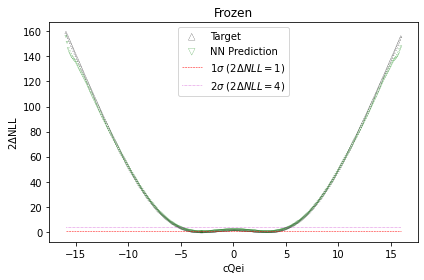

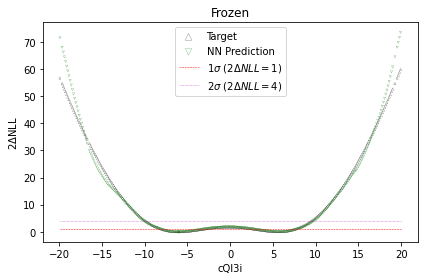

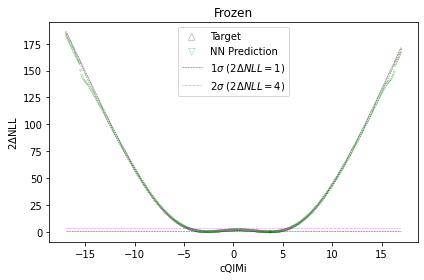

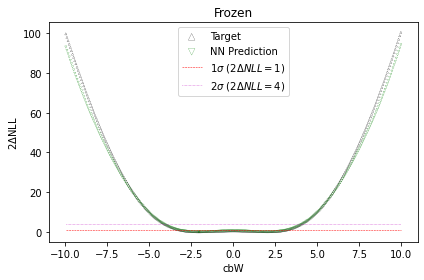

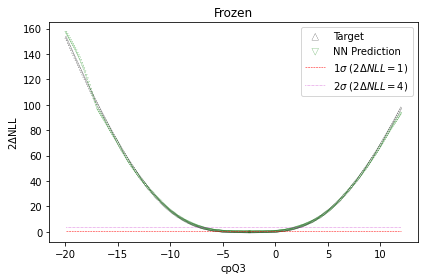

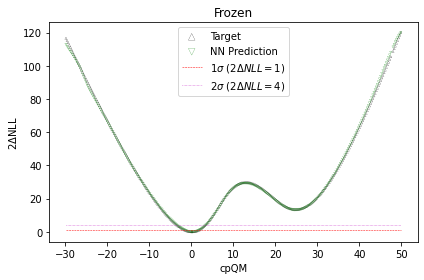

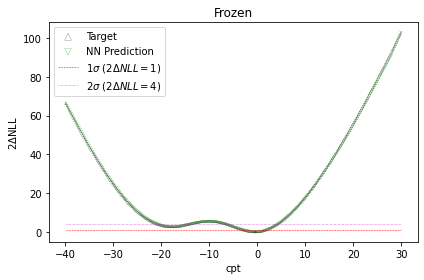

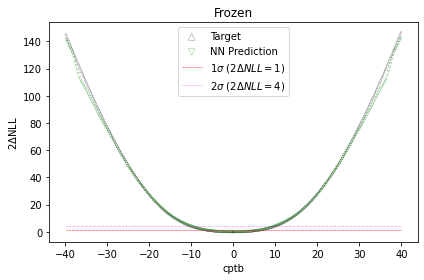

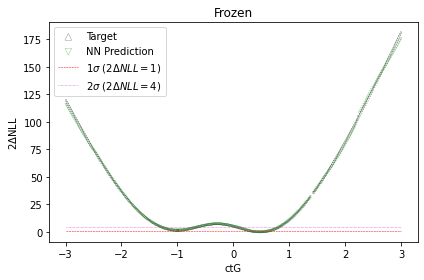

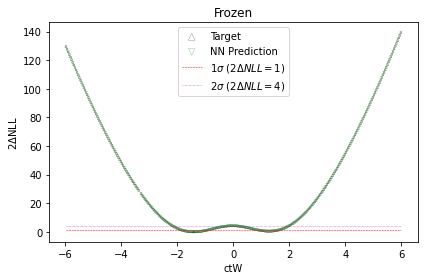

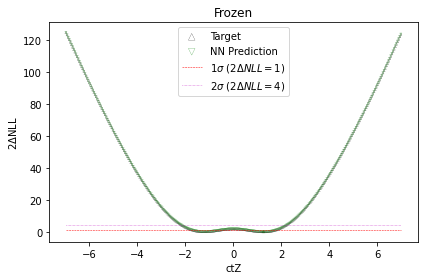

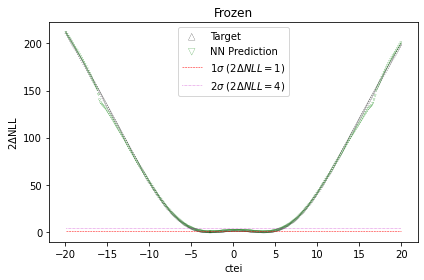

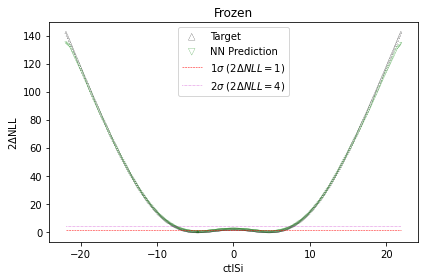

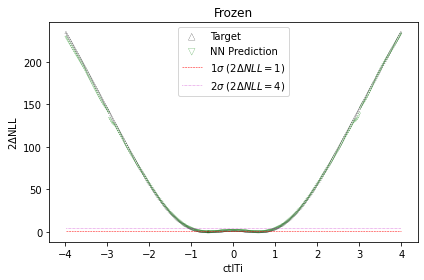

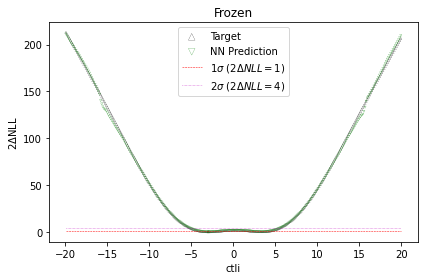

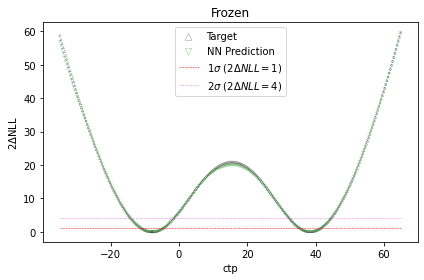

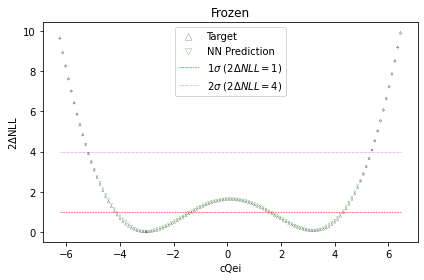

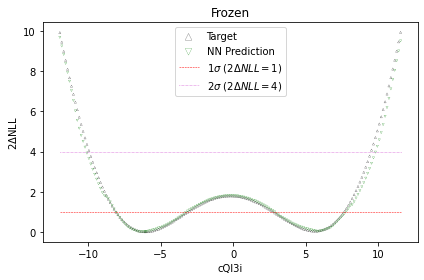

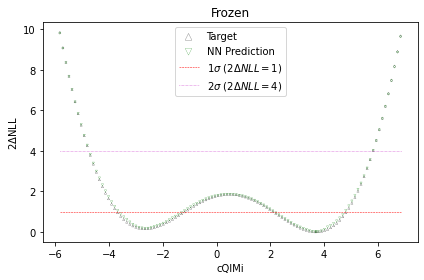

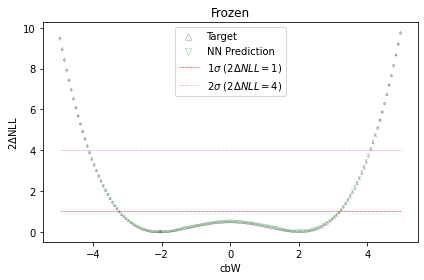

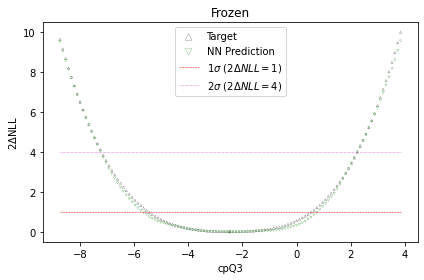

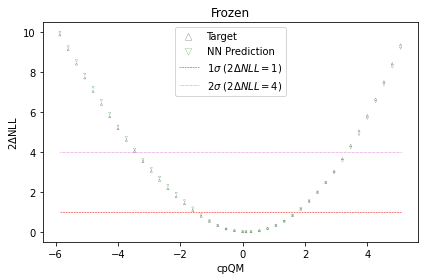

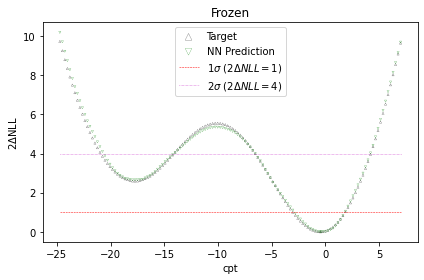

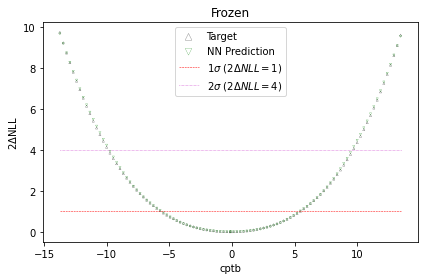

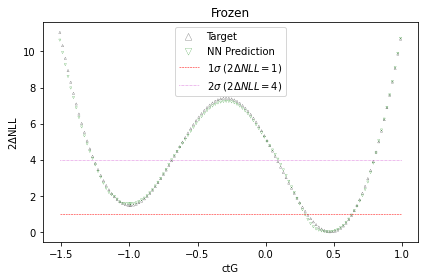

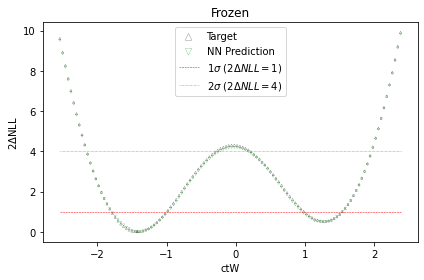

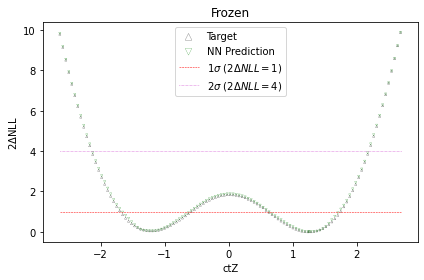

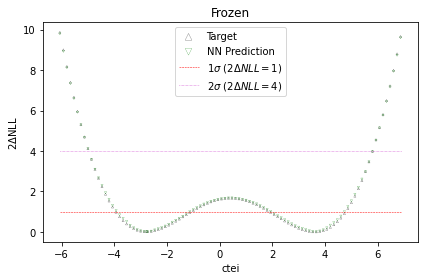

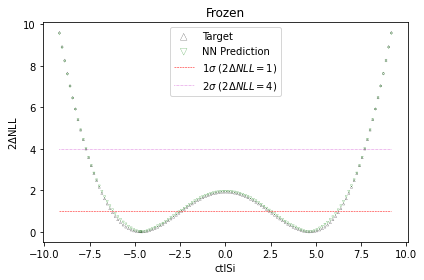

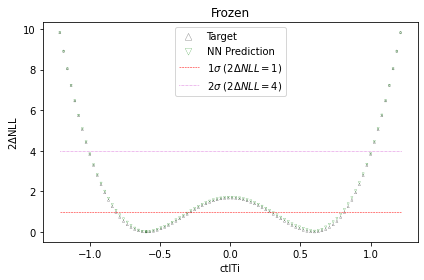

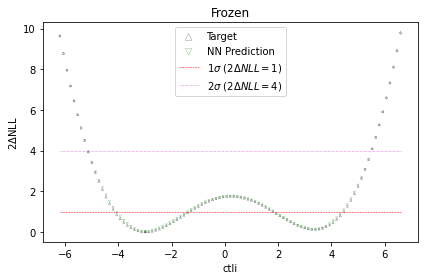

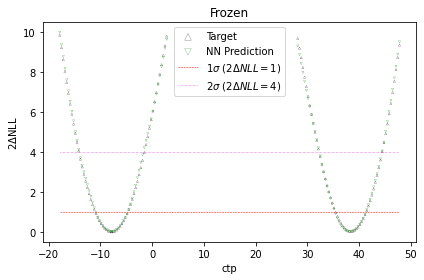

In [30]:
# 1D frozen graphs compared to Combine scans
frozen_1d_graphs = {}
for key in names.keys():
    target_1d_frozen_data[key]['2dNLL'] -= target_1d_frozen_data[key]['2dNLL'].min()
    model_1d_frozen_data[key]['2dNLL'] -= model_1d_frozen_data[key]['2dNLL'].min()
    frozen_1d_graphs[key] = plt.subplots()
    target_scatter = frozen_1d_graphs[key][1].scatter(target_1d_frozen_data[key][key], target_1d_frozen_data[key]['2dNLL'], marker='^', c='none', ec='k', s=5, linewidths=0.2)
    model_scatter = frozen_1d_graphs[key][1].scatter(model_1d_frozen_data[key][key], model_1d_frozen_data[key]['2dNLL'], marker='v', c='none', ec='g', s=5, linewidths=0.2)
    one_line, = frozen_1d_graphs[key][1].plot([target_1d_frozen_data[key][key].min(), target_1d_frozen_data[key][key].max()], [1,1], 'r--', linewidth=0.5)
    four_line, = frozen_1d_graphs[key][1].plot([target_1d_frozen_data[key][key].min(), target_1d_frozen_data[key][key].max()], [4,4], 'm:', linewidth=0.5)
    frozen_1d_graphs[key][1].legend([target_scatter, model_scatter, one_line, four_line], ['Target', 'NN Prediction', '$1\sigma\ (2\Delta NLL=1)$', '$2\sigma\ (2\Delta NLL=4)$'], markerscale=3)
    frozen_1d_graphs[key][1].set_xlabel(key)
    frozen_1d_graphs[key][1].set_ylabel('2$\Delta$NLL')
    frozen_1d_graphs[key][1].set_title('Frozen')
    frozen_1d_graphs[key][0].tight_layout()

'''
diff_frozen_1d_graphs = {}
for key in names.keys():
    diff_frozen_1d_graphs[key] = plt.subplots()
    diff_frozen_1d_graphs[key][1].scatter(diff_1d_frozen_data[key][key], diff_1d_frozen_data[key]['2dNLL'], c='b', s=1)
    diff_frozen_1d_graphs[key][1].set_xlabel(key)
    diff_frozen_1d_graphs[key][1].set_ylabel('residual (target - prediction)')
    diff_frozen_1d_graphs[key][1].set_title('Frozen')
    diff_frozen_1d_graphs[key][0].tight_layout()
'''
    
zoomed_frozen_1d_graphs = {}
for key in names.keys():
    target_1d_zoomed_frozen_data[key]['2dNLL'] -= target_1d_zoomed_frozen_data[key]['2dNLL'].min()
    model_1d_zoomed_frozen_data[key]['2dNLL'] -= model_1d_zoomed_frozen_data[key]['2dNLL'].min()
    zoomed_frozen_1d_graphs[key] = plt.subplots()
    target_scatter = zoomed_frozen_1d_graphs[key][1].scatter(target_1d_zoomed_frozen_data[key][key], target_1d_zoomed_frozen_data[key]['2dNLL'], marker='^', c='none', ec='k', s=5, linewidths=0.2)
    model_scatter = zoomed_frozen_1d_graphs[key][1].scatter(model_1d_zoomed_frozen_data[key][key], model_1d_zoomed_frozen_data[key]['2dNLL'], marker='v', c='none', ec='g', s=5, linewidths=0.2)
    one_line, = zoomed_frozen_1d_graphs[key][1].plot([target_1d_zoomed_frozen_data[key][key].min(), target_1d_zoomed_frozen_data[key][key].max()], [1,1], 'r--', linewidth=0.5)
    four_line, = zoomed_frozen_1d_graphs[key][1].plot([target_1d_zoomed_frozen_data[key][key].min(), target_1d_zoomed_frozen_data[key][key].max()], [4,4], 'm:', linewidth=0.5)
    zoomed_frozen_1d_graphs[key][1].legend([target_scatter, model_scatter, one_line, four_line], ['Target', 'NN Prediction', '$1\sigma\ (2\Delta NLL=1)$', '$2\sigma\ (2\Delta NLL=4)$'], markerscale=3)
    zoomed_frozen_1d_graphs[key][1].set_xlabel(key)
    zoomed_frozen_1d_graphs[key][1].set_ylabel('2$\Delta$NLL')
    zoomed_frozen_1d_graphs[key][1].set_title('Frozen')
    zoomed_frozen_1d_graphs[key][0].tight_layout()



In [31]:
# Save the graphs
for key in frozen_1d_graphs.keys():
    pp.savefig(frozen_1d_graphs[key][0])
'''
for key in diff_frozen_1d_graphs.keys():
    pp.savefig(diff_frozen_1d_graphs[key][0])
'''
for key in zoomed_frozen_1d_graphs.keys():
    pp.savefig(zoomed_frozen_1d_graphs[key][0])

/srv/ipykernel_333/203470665.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  zoomed_fake_profiled_1d_graphs[key] = plt.subplots()


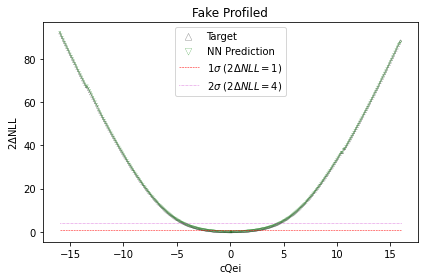

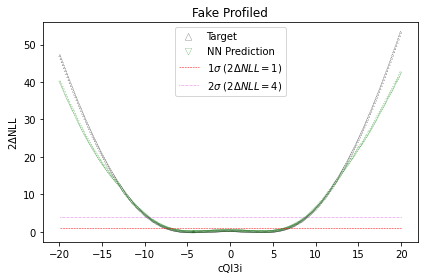

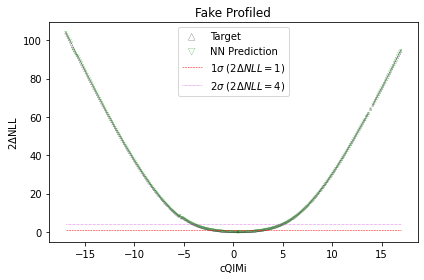

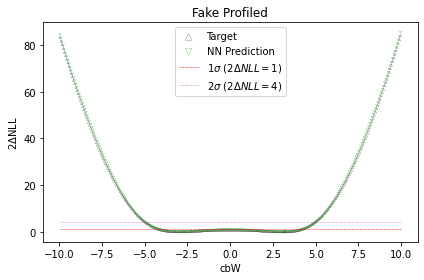

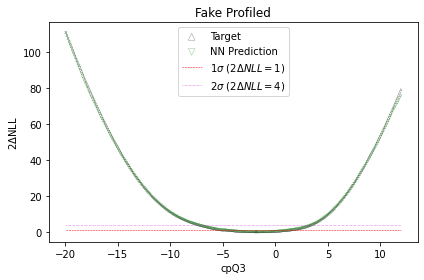

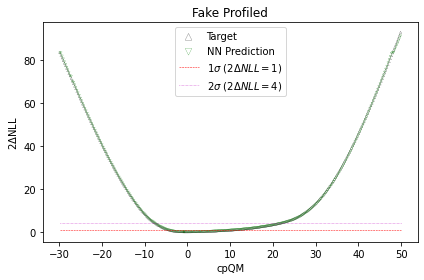

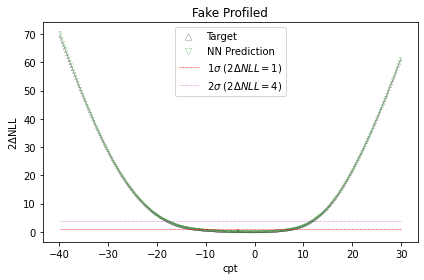

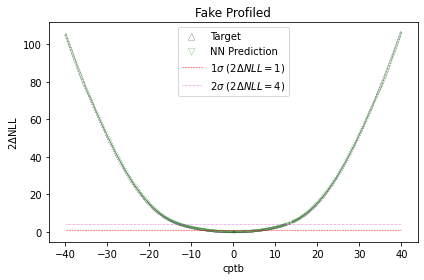

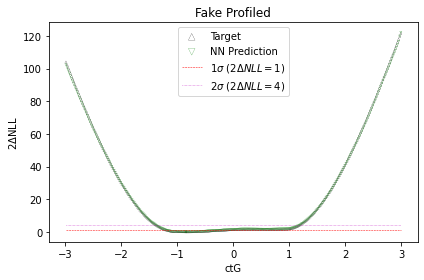

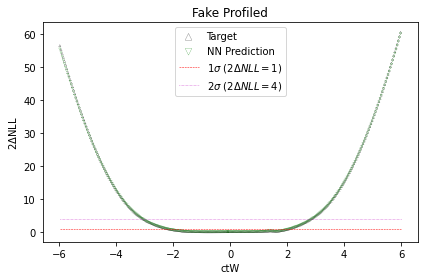

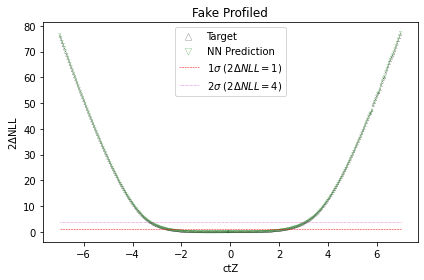

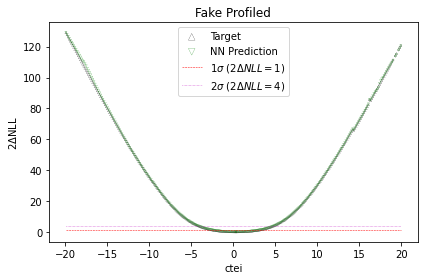

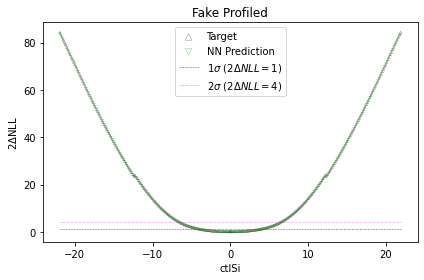

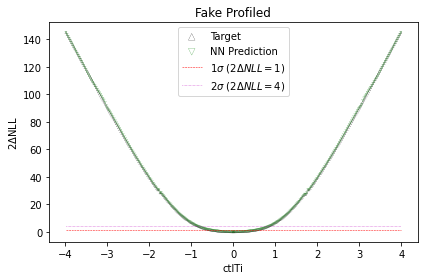

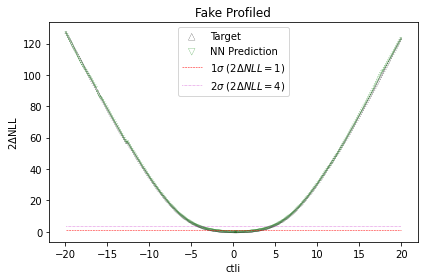

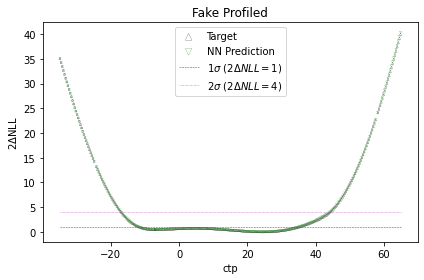

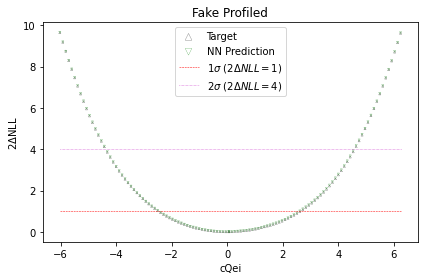

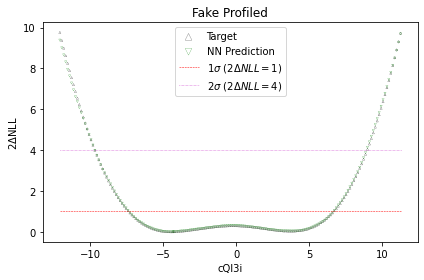

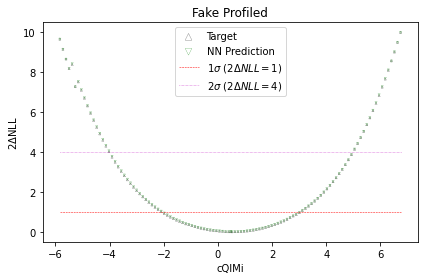

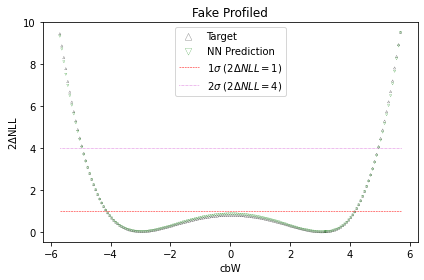

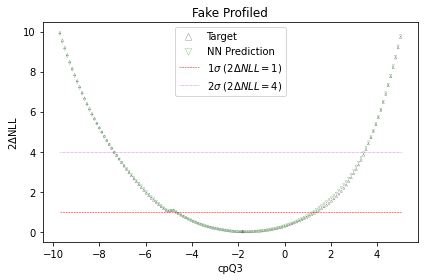

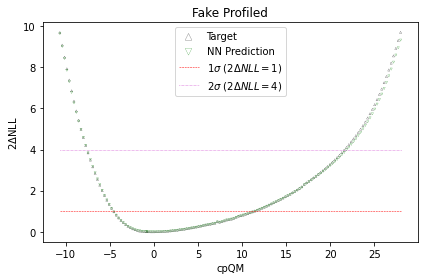

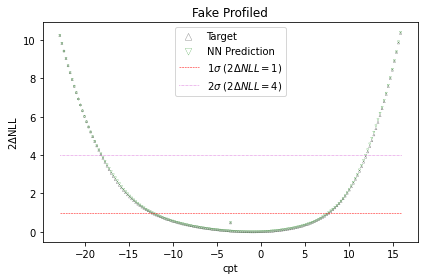

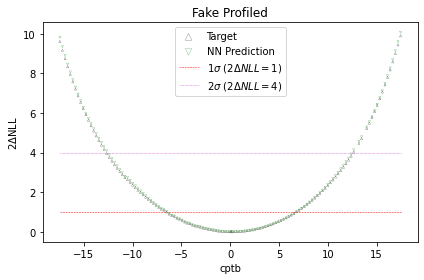

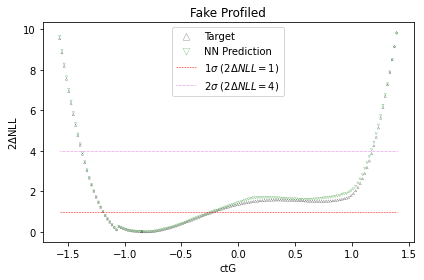

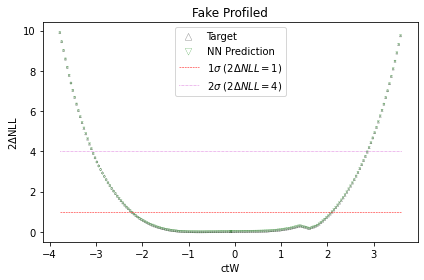

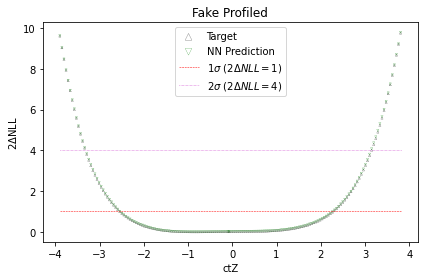

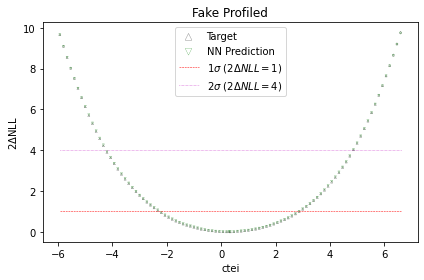

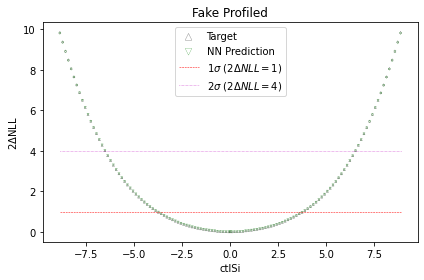

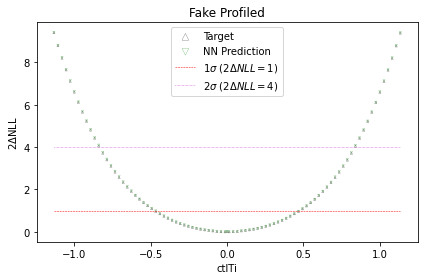

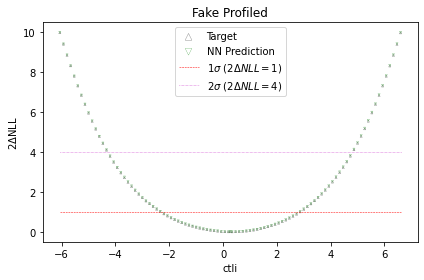

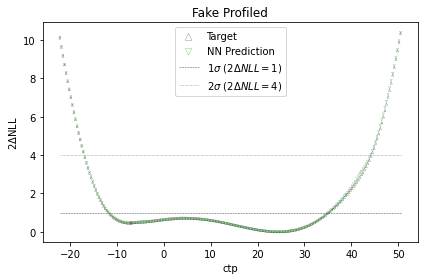

In [32]:
# 1D fake profiled graphs compared to Combine scans
fake_profiled_1d_graphs = {}
for key in names.keys():
    target_1d_fake_profiled_data[key]['2dNLL'] -= target_1d_fake_profiled_data[key]['2dNLL'].min()
    model_1d_fake_profiled_data[key]['2dNLL'] -= model_1d_fake_profiled_data[key]['2dNLL'].min()
    fake_profiled_1d_graphs[key] = plt.subplots()
    target_scatter = fake_profiled_1d_graphs[key][1].scatter(target_1d_fake_profiled_data[key]['all_WCs'][:,names[key]], target_1d_fake_profiled_data[key]['2dNLL'], marker='^', c='none', ec='k', s=5, linewidths=0.2)
    model_scatter = fake_profiled_1d_graphs[key][1].scatter(model_1d_fake_profiled_data[key]['all_WCs'][:,names[key]], model_1d_fake_profiled_data[key]['2dNLL'], marker='v', c='none', ec='g', s=5, linewidths=0.2)
    one_line, = fake_profiled_1d_graphs[key][1].plot([target_1d_fake_profiled_data[key]['all_WCs'][:,names[key]].min(), target_1d_fake_profiled_data[key]['all_WCs'][:,names[key]].max()], [1,1], 'r--', linewidth=0.5)
    four_line, = fake_profiled_1d_graphs[key][1].plot([target_1d_fake_profiled_data[key]['all_WCs'][:,names[key]].min(), target_1d_fake_profiled_data[key]['all_WCs'][:,names[key]].max()], [4,4], 'm:', linewidth=0.5)
    fake_profiled_1d_graphs[key][1].legend([target_scatter, model_scatter, one_line, four_line], ['Target', 'NN Prediction', '$1\sigma\ (2\Delta NLL=1)$', '$2\sigma\ (2\Delta NLL=4)$'], markerscale=3)
    fake_profiled_1d_graphs[key][1].set_xlabel(key)
    fake_profiled_1d_graphs[key][1].set_ylabel('2$\Delta$NLL')
    fake_profiled_1d_graphs[key][1].set_title('Fake Profiled')
    fake_profiled_1d_graphs[key][0].tight_layout()

zoomed_fake_profiled_1d_graphs = {}
for key in names.keys():
    target_1d_zoomed_fake_profiled_data[key]['2dNLL'] -= target_1d_zoomed_fake_profiled_data[key]['2dNLL'].min()
    model_1d_zoomed_fake_profiled_data[key]['2dNLL'] -= model_1d_zoomed_fake_profiled_data[key]['2dNLL'].min()
    zoomed_fake_profiled_1d_graphs[key] = plt.subplots()
    target_scatter = zoomed_fake_profiled_1d_graphs[key][1].scatter(target_1d_zoomed_fake_profiled_data[key]['all_WCs'][:,names[key]], target_1d_zoomed_fake_profiled_data[key]['2dNLL'], marker='^', c='none', ec='k', s=5, linewidths=0.2)
    model_scatter = zoomed_fake_profiled_1d_graphs[key][1].scatter(model_1d_zoomed_fake_profiled_data[key]['all_WCs'][:,names[key]], model_1d_zoomed_fake_profiled_data[key]['2dNLL'], marker='v', c='none', ec='g', s=5, linewidths=0.2)
    one_line, = zoomed_fake_profiled_1d_graphs[key][1].plot([target_1d_zoomed_fake_profiled_data[key]['all_WCs'][:,names[key]].min(), target_1d_zoomed_fake_profiled_data[key]['all_WCs'][:,names[key]].max()], [1,1], 'r--', linewidth=0.5)
    four_line, = zoomed_fake_profiled_1d_graphs[key][1].plot([target_1d_zoomed_fake_profiled_data[key]['all_WCs'][:,names[key]].min(), target_1d_zoomed_fake_profiled_data[key]['all_WCs'][:,names[key]].max()], [4,4], 'm:', linewidth=0.5)
    zoomed_fake_profiled_1d_graphs[key][1].legend([target_scatter, model_scatter, one_line, four_line], ['Target', 'NN Prediction', '$1\sigma\ (2\Delta NLL=1)$', '$2\sigma\ (2\Delta NLL=4)$'], markerscale=3)
    zoomed_fake_profiled_1d_graphs[key][1].set_xlabel(key)
    zoomed_fake_profiled_1d_graphs[key][1].set_ylabel('2$\Delta$NLL')
    zoomed_fake_profiled_1d_graphs[key][1].set_title('Fake Profiled')
    zoomed_fake_profiled_1d_graphs[key][0].tight_layout()

In [33]:
# Save the graphs
for key in fake_profiled_1d_graphs.keys():
    pp.savefig(fake_profiled_1d_graphs[key][0])
for key in zoomed_fake_profiled_1d_graphs.keys():
    pp.savefig(zoomed_fake_profiled_1d_graphs[key][0])

"\ndiff_frozen_2d_graphs = {}\nfor num in np.arange(8):\n    diff_frozen_2d_graphs[str(num)] = plt.subplots()\n    im = diff_frozen_2d_graphs[str(num)][1].tripcolor(diff_2d_frozen_data[str(num)][WC2d_2[num]], diff_2d_frozen_data[str(num)][WC2d_1[num]], diff_2d_frozen_data[str(num)]['2dNLL'])\n    diff_frozen_2d_graphs[str(num)][1].set_xlabel(WC2d_2[num])\n    diff_frozen_2d_graphs[str(num)][1].set_ylabel(WC2d_1[num])\n    diff_frozen_2d_graphs[str(num)][1].set_title('Frozen')\n    diff_frozen_2d_graphs[str(num)][0].colorbar(im, ax=diff_frozen_2d_graphs[str(num)][1], label='target - prediction')\n    diff_frozen_2d_graphs[str(num)][0].tight_layout()\n"

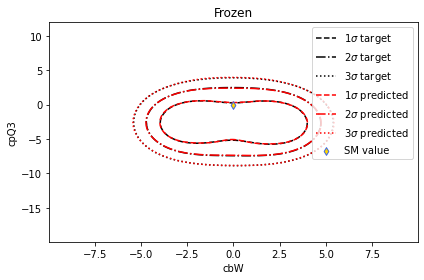

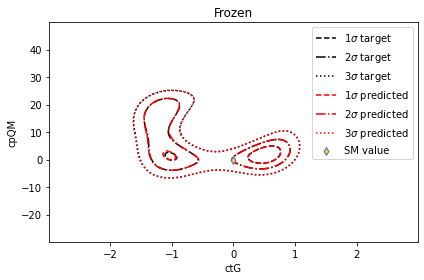

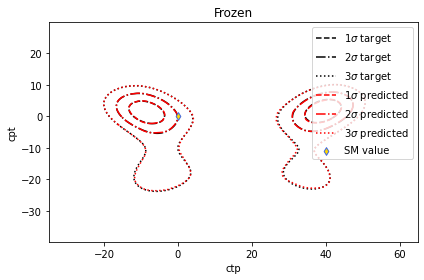

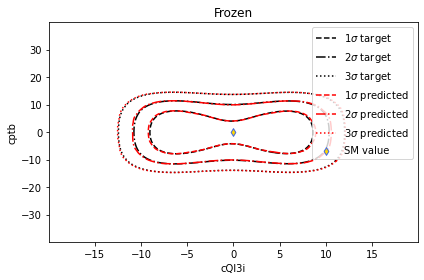

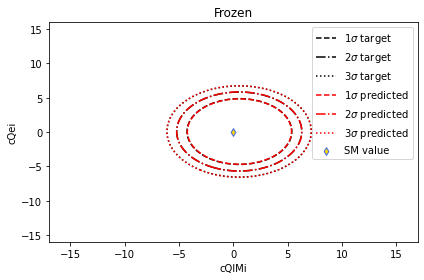

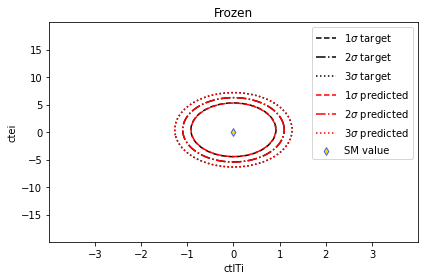

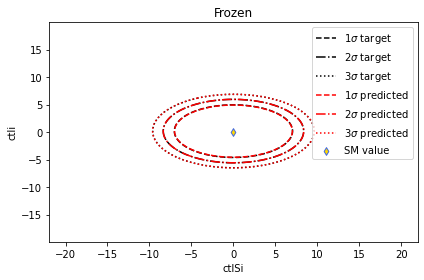

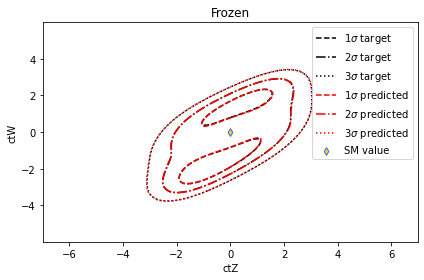

In [34]:
# 2D frozen graphs compared to Combine scans
frozen_2d_graphs = {}
for num in np.arange(8):
    target_2d_frozen_data[str(num)]['2dNLL'] -= target_2d_frozen_data[str(num)]['2dNLL'].min()
    model_2d_frozen_data[str(num)]['2dNLL'] -= model_2d_frozen_data[str(num)]['2dNLL'].min()
    frozen_2d_graphs[str(num)] = plt.subplots()
    target_contour = frozen_2d_graphs[str(num)][1].tricontour(target_2d_frozen_data[str(num)][WC2d_2[num]], target_2d_frozen_data[str(num)][WC2d_1[num]], target_2d_frozen_data[str(num)]['2dNLL'], colors='k', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    model_contour = frozen_2d_graphs[str(num)][1].tricontour(model_2d_frozen_data[str(num)][WC2d_2[num]], model_2d_frozen_data[str(num)][WC2d_1[num]], model_2d_frozen_data[str(num)]['2dNLL'], colors='r', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    SM_value = frozen_2d_graphs[str(num)][1].scatter(0, 0, marker='d', c='gold', ec='royalblue', s=30, linewidths=1, zorder=10)
    frozen_2d_graphs[str(num)][1].legend(target_contour.collections+model_contour.collections+[SM_value], ['$1\sigma$ target', '$2\sigma$ target', '$3\sigma$ target', '$1\sigma$ predicted', '$2\sigma$ predicted', '$3\sigma$ predicted', 'SM value'])
    frozen_2d_graphs[str(num)][1].set_xlabel(WC2d_2[num])
    frozen_2d_graphs[str(num)][1].set_ylabel(WC2d_1[num])
    frozen_2d_graphs[str(num)][1].set_title('Frozen')
    frozen_2d_graphs[str(num)][0].tight_layout()

'''
diff_frozen_2d_graphs = {}
for num in np.arange(8):
    diff_frozen_2d_graphs[str(num)] = plt.subplots()
    im = diff_frozen_2d_graphs[str(num)][1].tripcolor(diff_2d_frozen_data[str(num)][WC2d_2[num]], diff_2d_frozen_data[str(num)][WC2d_1[num]], diff_2d_frozen_data[str(num)]['2dNLL'])
    diff_frozen_2d_graphs[str(num)][1].set_xlabel(WC2d_2[num])
    diff_frozen_2d_graphs[str(num)][1].set_ylabel(WC2d_1[num])
    diff_frozen_2d_graphs[str(num)][1].set_title('Frozen')
    diff_frozen_2d_graphs[str(num)][0].colorbar(im, ax=diff_frozen_2d_graphs[str(num)][1], label='target - prediction')
    diff_frozen_2d_graphs[str(num)][0].tight_layout()
'''

In [35]:
# Save the graphs
for key in frozen_2d_graphs.keys():
    pp.savefig(frozen_2d_graphs[key][0])
'''
for key in diff_frozen_2d_graphs.keys():
    pp.savefig(diff_frozen_2d_graphs[key][0])
'''

'\nfor key in diff_frozen_2d_graphs.keys():\n    pp.savefig(diff_frozen_2d_graphs[key][0])\n'

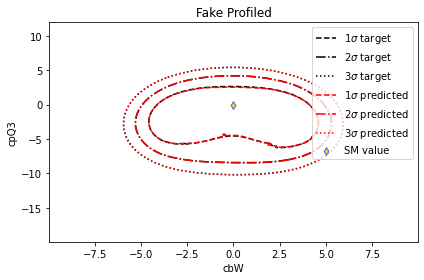

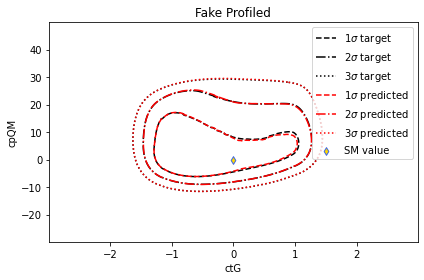

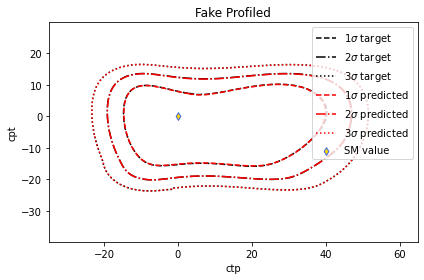

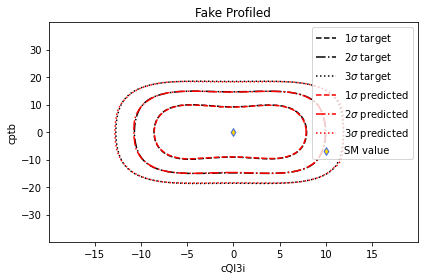

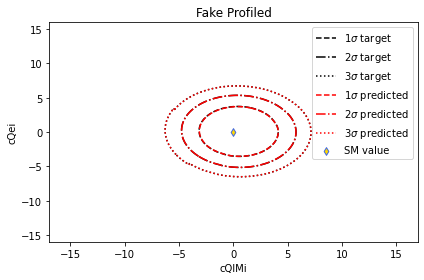

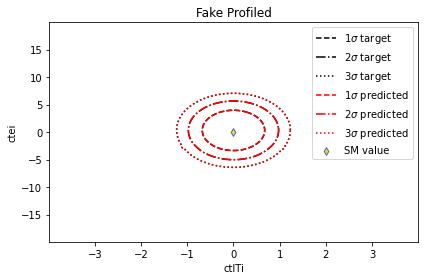

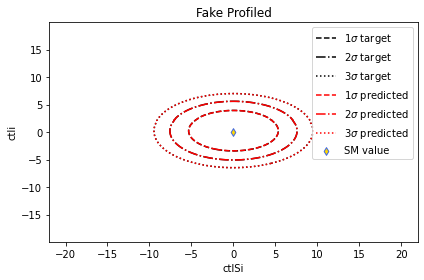

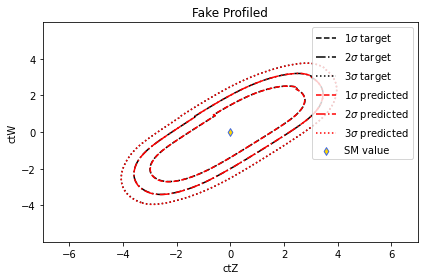

In [36]:
# 2D fake profiled graphs compared to Combine scans
fake_profiled_2d_graphs = {}
for num in np.arange(8):
    target_2d_profiled_data[str(num)]['2dNLL'] -= target_2d_profiled_data[str(num)]['2dNLL'].min()
    model_2d_fake_profiled_data[str(num)]['2dNLL'] -= model_2d_fake_profiled_data[str(num)]['2dNLL'].min()
    fake_profiled_2d_graphs[str(num)] = plt.subplots()
    target_contour = fake_profiled_2d_graphs[str(num)][1].tricontour(target_2d_profiled_data[str(num)]['all_WCs'][:, names[WC2d_2[num]]], target_2d_profiled_data[str(num)]['all_WCs'][:, names[WC2d_1[num]]], target_2d_profiled_data[str(num)]['2dNLL'], colors='k', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    model_contour = fake_profiled_2d_graphs[str(num)][1].tricontour(model_2d_fake_profiled_data[str(num)]['all_WCs'][:, names[WC2d_2[num]]], model_2d_fake_profiled_data[str(num)]['all_WCs'][:, names[WC2d_1[num]]], model_2d_fake_profiled_data[str(num)]['2dNLL'], colors='r', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    SM_value = fake_profiled_2d_graphs[str(num)][1].scatter(0, 0, marker='d', c='gold', ec='royalblue', s=30, linewidths=1, zorder=10)
    fake_profiled_2d_graphs[str(num)][1].legend(target_contour.collections+model_contour.collections+[SM_value], ['$1\sigma$ target', '$2\sigma$ target', '$3\sigma$ target', '$1\sigma$ predicted', '$2\sigma$ predicted', '$3\sigma$ predicted', 'SM value'])
    fake_profiled_2d_graphs[str(num)][1].set_xlabel(WC2d_2[num])
    fake_profiled_2d_graphs[str(num)][1].set_ylabel(WC2d_1[num])
    fake_profiled_2d_graphs[str(num)][1].set_title('Fake Profiled')
    fake_profiled_2d_graphs[str(num)][0].tight_layout()

In [37]:
# Save the graphs
for key in fake_profiled_2d_graphs.keys():
    pp.savefig(fake_profiled_2d_graphs[key][0])

/srv/ipykernel_333/592979048.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  zoomed_profiled_1d_graphs[key] = plt.subplots()


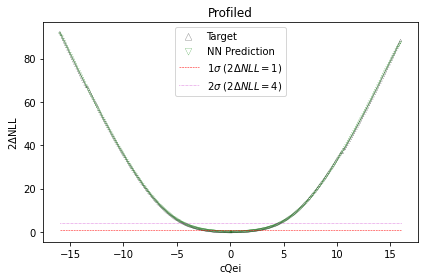

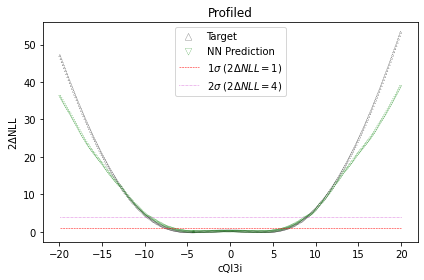

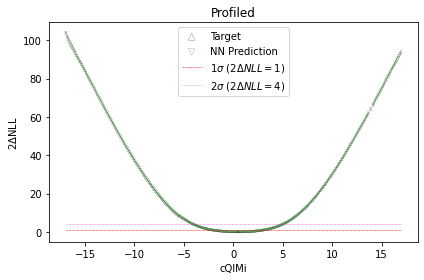

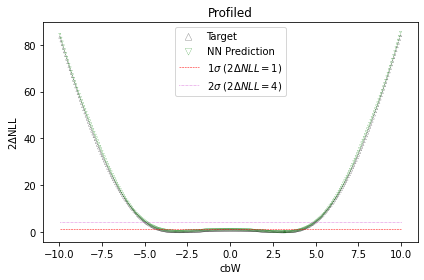

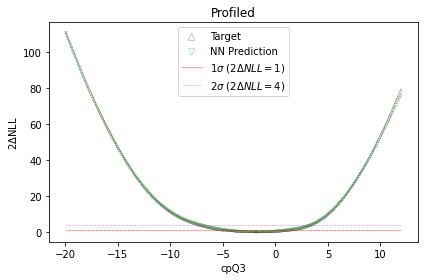

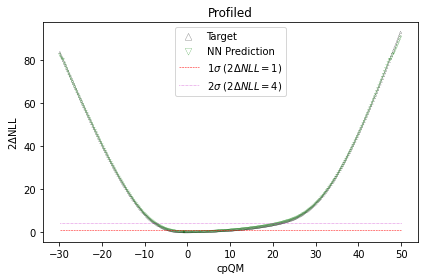

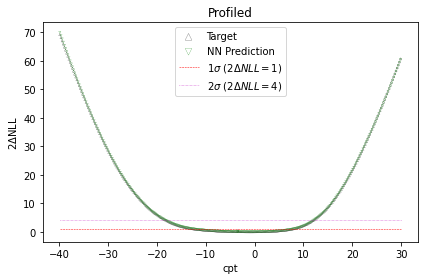

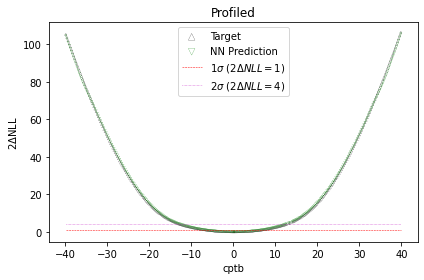

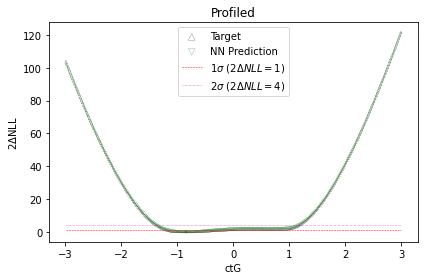

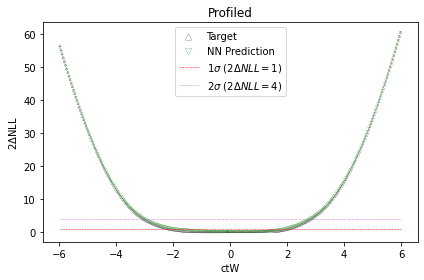

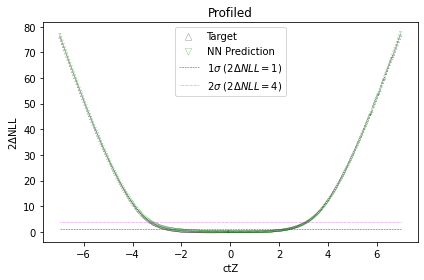

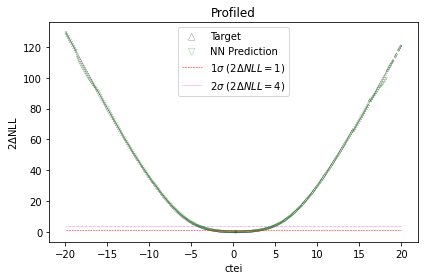

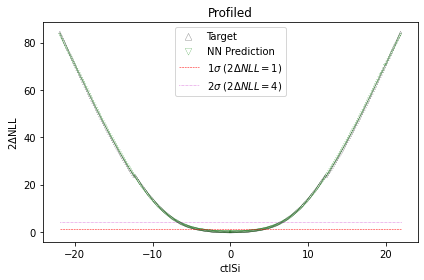

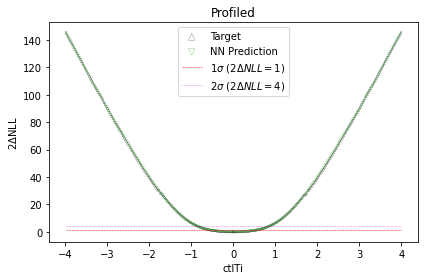

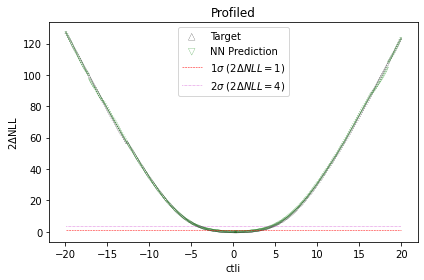

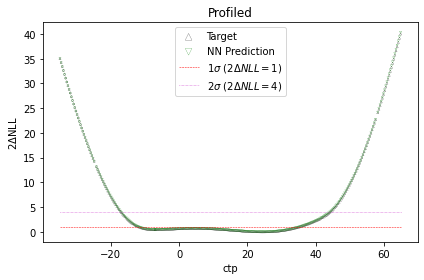

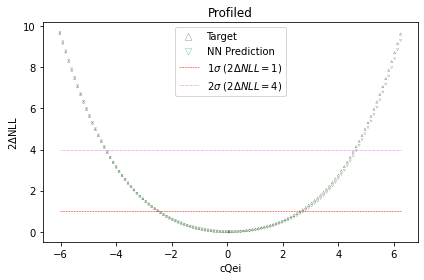

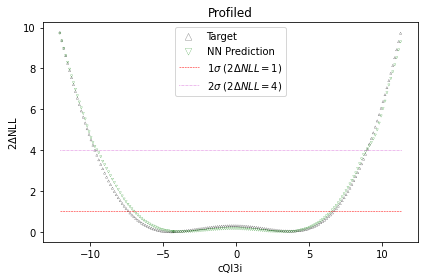

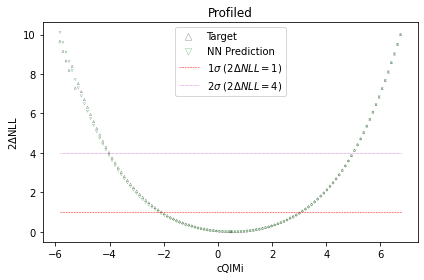

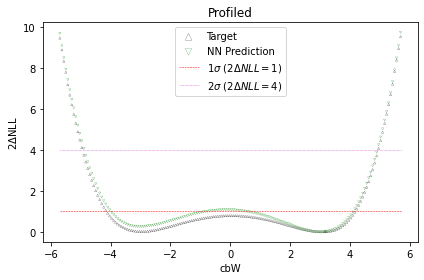

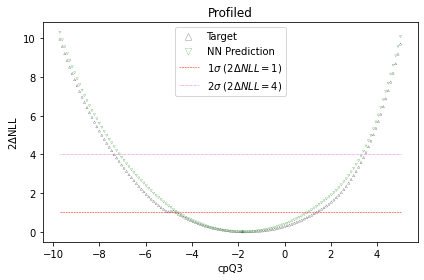

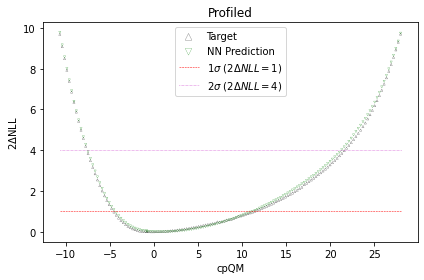

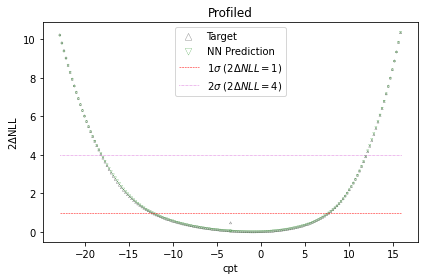

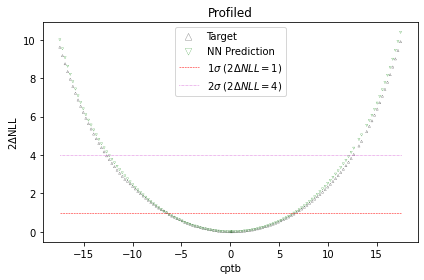

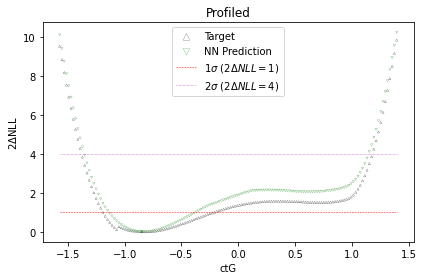

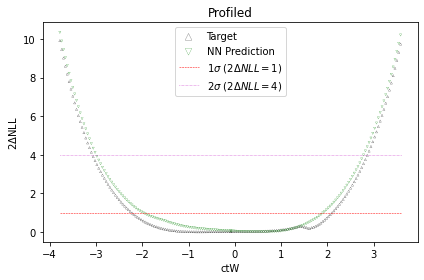

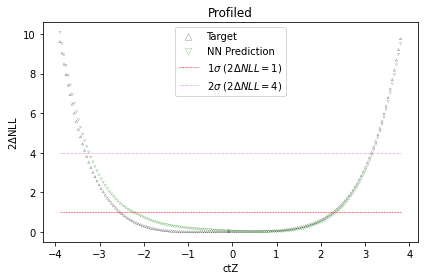

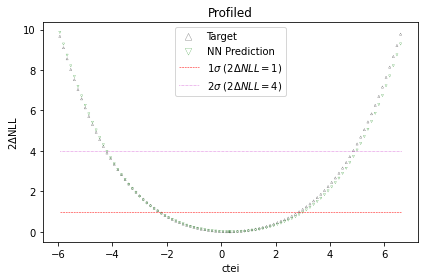

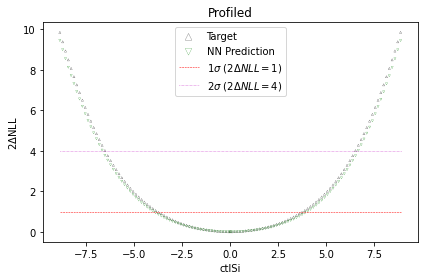

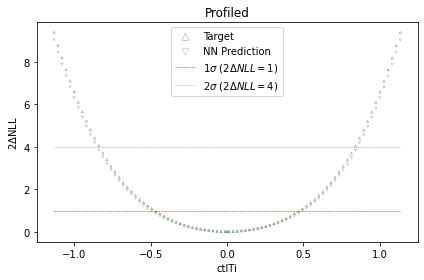

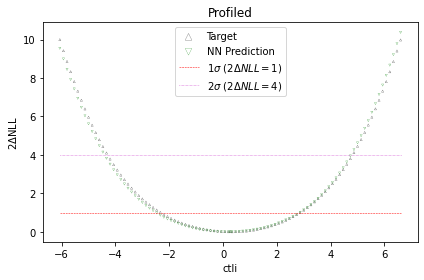

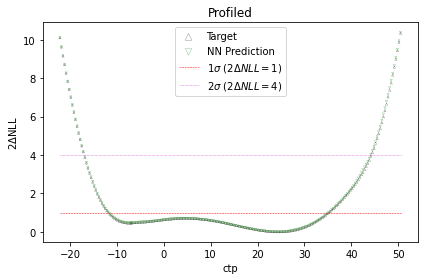

In [38]:
# 1D real profiled graphs compared to Combine scans
profiled_1d_graphs = {}
for key in names.keys():
    # Now have to shift because training data is shifted to 0
    target_1d_profiled_data[key]['2dNLL'] -= target_1d_profiled_data[key]['2dNLL'].min()
    model_1d_profiled_data[key]['2dNLL'] -= model_1d_profiled_data[key]['2dNLL'].min()
    profiled_1d_graphs[key] = plt.subplots()
    target_scatter = profiled_1d_graphs[key][1].scatter(target_1d_profiled_data[key][key], target_1d_profiled_data[key]['2dNLL'], marker='^', c='none', ec='k', s=5, linewidths=0.2)
    model_scatter = profiled_1d_graphs[key][1].scatter(model_1d_profiled_data[key]['all_WCs'][:,names[key]], model_1d_profiled_data[key]['2dNLL'], marker='v', c='none', ec='g', s=5, linewidths=0.2)
    one_line, = profiled_1d_graphs[key][1].plot([target_1d_profiled_data[key][key].min(), target_1d_profiled_data[key][key].max()], [1,1], 'r--', linewidth=0.5)
    four_line, = profiled_1d_graphs[key][1].plot([target_1d_profiled_data[key][key].min(), target_1d_profiled_data[key][key].max()], [4,4], 'm:', linewidth=0.5)
    profiled_1d_graphs[key][1].legend([target_scatter, model_scatter, one_line, four_line], ['Target', 'NN Prediction', '$1\sigma\ (2\Delta NLL=1)$', '$2\sigma\ (2\Delta NLL=4)$'], markerscale=3)
    profiled_1d_graphs[key][1].set_xlabel(key)
    profiled_1d_graphs[key][1].set_ylabel('2$\Delta$NLL')
    profiled_1d_graphs[key][1].set_title('Profiled')
    profiled_1d_graphs[key][0].tight_layout()

zoomed_profiled_1d_graphs = {}
for key in names.keys():
    target_1d_zoomed_profiled_data[key]['2dNLL'] -= target_1d_zoomed_profiled_data[key]['2dNLL'].min()
    model_1d_zoomed_profiled_data[key]['2dNLL'] -= model_1d_zoomed_profiled_data[key]['2dNLL'].min()
    zoomed_profiled_1d_graphs[key] = plt.subplots()
    target_scatter = zoomed_profiled_1d_graphs[key][1].scatter(target_1d_zoomed_profiled_data[key][key], target_1d_zoomed_profiled_data[key]['2dNLL'], marker='^', c='none', ec='k', s=5, linewidths=0.2)
    model_scatter = zoomed_profiled_1d_graphs[key][1].scatter(model_1d_zoomed_profiled_data[key]['all_WCs'][:,names[key]], model_1d_zoomed_profiled_data[key]['2dNLL'], marker='v', c='none', ec='g', s=5, linewidths=0.2)
    one_line, = zoomed_profiled_1d_graphs[key][1].plot([target_1d_zoomed_profiled_data[key][key].min(), target_1d_zoomed_profiled_data[key][key].max()], [1,1], 'r--', linewidth=0.5)
    four_line, = zoomed_profiled_1d_graphs[key][1].plot([target_1d_zoomed_profiled_data[key][key].min(), target_1d_zoomed_profiled_data[key][key].max()], [4,4], 'm:', linewidth=0.5)
    zoomed_profiled_1d_graphs[key][1].legend([target_scatter, model_scatter, one_line, four_line], ['Target', 'NN Prediction', '$1\sigma\ (2\Delta NLL=1)$', '$2\sigma\ (2\Delta NLL=4)$'], markerscale=3)
    zoomed_profiled_1d_graphs[key][1].set_xlabel(key)
    zoomed_profiled_1d_graphs[key][1].set_ylabel('2$\Delta$NLL')
    zoomed_profiled_1d_graphs[key][1].set_title('Profiled')
    zoomed_profiled_1d_graphs[key][0].tight_layout()

In [39]:
# Save the graphs
for key in profiled_1d_graphs.keys():
    pp.savefig(profiled_1d_graphs[key][0])
for key in zoomed_profiled_1d_graphs.keys():
    pp.savefig(zoomed_profiled_1d_graphs[key][0])

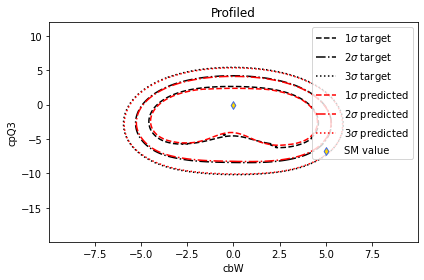

In [40]:
# 2D real profiled graphs compared to Combine scans
profiled_2d_graphs = {}
for num in nums:
    target_2d_profiled_data[str(num)]['2dNLL'] -= target_2d_profiled_data[str(num)]['2dNLL'].min()
    model_2d_profiled_data[str(num)]['2dNLL'] -= model_2d_profiled_data[str(num)]['2dNLL'].min()
    profiled_2d_graphs[str(num)] = plt.subplots()
    target_contour = profiled_2d_graphs[str(num)][1].tricontour(target_2d_profiled_data[str(num)]['all_WCs'][:, names[WC2d_2[num]]], target_2d_profiled_data[str(num)]['all_WCs'][:, names[WC2d_1[num]]], target_2d_profiled_data[str(num)]['2dNLL'], colors='k', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    model_contour = profiled_2d_graphs[str(num)][1].tricontour(model_2d_profiled_data[str(num)]['all_WCs'][:, names[WC2d_2[num]]], model_2d_profiled_data[str(num)]['all_WCs'][:, names[WC2d_1[num]]], model_2d_profiled_data[str(num)]['2dNLL'], colors='r', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    SM_value = profiled_2d_graphs[str(num)][1].scatter(0, 0, marker='d', c='gold', ec='royalblue', s=30, linewidths=1, zorder=10)
    profiled_2d_graphs[str(num)][1].legend(target_contour.collections+model_contour.collections+[SM_value], ['$1\sigma$ target', '$2\sigma$ target', '$3\sigma$ target', '$1\sigma$ predicted', '$2\sigma$ predicted', '$3\sigma$ predicted', 'SM value'])
    profiled_2d_graphs[str(num)][1].set_xlabel(WC2d_2[num])
    profiled_2d_graphs[str(num)][1].set_ylabel(WC2d_1[num])
    profiled_2d_graphs[str(num)][1].set_title('Profiled')
    profiled_2d_graphs[str(num)][0].tight_layout()

In [41]:
# Save the graphs
for key in profiled_2d_graphs.keys():
    pp.savefig(profiled_2d_graphs[key][0])

In [42]:
# Save the graphs and data to files
np.savez(f'./graphs/{out_file}_validation.npz', **data_dict)
pp.close()